# Ele faz divisões 

Nota técnica disso e aquilo

In [1]:
# adding br_demography to Python Path
import sys 
sys.path.append("../../")

from br_demography  import municipality_migration as mm
from br_demography  import municipality_births as mb
import basedosdados as bd
from dotenv import load_dotenv
import os
import pandas as pd # importação de biblioteca de manipulação de dados tabulares
import matplotlib.pyplot as plt # importação de biblioteca de plotagem de gráficos 
import numpy as np # importação de biblioteca para cálculos matemáticos
from scipy.optimize import curve_fit # importação de função a ser utilizada para ajuste de modelo preditivo 
from itertools import product # importação de função voltada para otimização de laços de iteração
import warnings
import scipy

import sklearn
# Carrega as variáveis de ambiente do arquivo .env
load_dotenv(dotenv_path='../../.env')

# Use as variáveis de ambiente conforme necessário
project_id = os.getenv('GOOGLE_CLOUD_PROJECT_ID')

### Dados de Nascimento

In [2]:
df_mun = pd.read_csv('../../br_demography/source/tab/cod_mun.csv', sep=';', index_col='mun_id')

dict_dfs = dict()

for mun_id, mun in df_mun.itertuples():
    df_births_mun = mb.query_births(mun_id=mun_id, project_id=project_id, start_year=2000, end_year=2022)
    df_births_mun = mb.standard_age_groups(df=df_births_mun, age_group_csv_path='../../br_demography/source/tab/faixas_etarias_maes.csv')
    df_births_mun = df_births_mun.reset_index().pivot_table(columns=['Ano'], index=['Faixa Etária'], values=['Nascimentos'])
    df_births_mun = df_births_mun.droplevel(level=0, axis=1)
    df_births_mun.columns.name = None
    df_births_mun['Município'] = mun
    df_births_mun = df_births_mun.reset_index().set_index(['Município', 'Faixa Etária'])
    
    dict_dfs[mun] = df_births_mun

df_births = pd.concat(objs=dict_dfs.values())

Downloading: 100%|██████████| 1800/1800 [00:00<00:00, 4163.30rows/s]


In [3]:
df_births.to_csv(path_or_buf='../../br_demography/results/tab/nascimentos_rmc_2000_2022.csv', sep=';', decimal=',', encoding='utf-16')

### Dados de População de Sexo Feminino entre 2000 e 2022 

In [4]:
df_pop = pd.read_csv(filepath_or_buffer='../../br_demography/results/tab/pop_municipios_rmc_2000_2022_estimativa_intercensitaria.csv', sep=';')
df_pop = df_pop[df_pop['Sexo'] == 'Feminino'].drop(columns=['Sexo'])
df_pop = df_pop[df_pop['Faixa Etária'].isin(values=df_births_mun.reset_index()['Faixa Etária'].values)]
df_pop.set_index(keys=['Município', 'Faixa Etária'], inplace=True)
df_pop.columns = df_pop.columns.astype(int)
df_pop


2000  2001  2002  2003  2004  2005  2006  2007  \
Município       Faixa Etária                                                   
Adrianópolis    10 a 19 anos   823   798   775   752   730   708   687   667   
                20 a 29 anos   437   435   434   433   431   430   429   427   
                30 a 39 anos   439   432   426   420   413   407   401   396   
                40 a 49 anos   338   343   348   353   359   364   370   376   
Agudos do Sul   10 a 19 anos   666   677   688   700   712   724   736   749   
...                            ...   ...   ...   ...   ...   ...   ...   ...   
Tunas do Paraná 40 a 49 anos   212   219   226   233   241   249   257   266   
Doutor Ulysses  10 a 19 anos   643   641   639   637   635   633   632   630   
                20 a 29 anos   468   460   452   444   437   429   422   415   
                30 a 39 anos   373   376   379   382   385   389   392   395   
                40 a 49 anos   228   234   241   248   255   262   269   277   

                              2008  2009  ...  2013  2014  2015  2016  2017  \
Município       Faixa Etária              ...                                 
Adrianópolis    10 a 19 anos   647   628  ...   576   565   555   545   534   
                20 a 29 anos   426   425  ...   413   410   406   403   400   
                30 a 39 anos   390   384  ...   384   385   387   389   391   
                40 a 49 anos   382   388  ...   395   396   397   397   398   
Agudos do Sul   10 a 19 anos   761   774  ...   770   765   759   753   748   
...                            ...   ...  ...   ...   ...   ...   ...   ...   
Tunas do Paraná 40 a 49 anos   275   284  ...   315   322   330   338   346   
Doutor Ulysses  10 a 19 anos   628   626  ...   571   554   537   522   506   
                20 a 29 anos   408   401  ...   392   391   390   389   388   
                30 a 39 anos   399   402  ...   407   408   409   409   410   
                40 a 49 anos   285   293  ...   322   329   337   344   352   

                              2018  2019  2020  2021  2022  
Município       Faixa Etária                                
Adrianópolis    10 a 19 anos   524   515   505   496   487  
                20 a 29 anos   396   393   390   387   384  
                30 a 39 anos   392   394   396   398   400  
                40 a 49 anos   399   399   400   401   402  
Agudos do Sul   10 a 19 anos   742   737   731   726   721  
...                            ...   ...   ...   ...   ...  
Tunas do Paraná 40 a 49 anos   354   362   371   380   389  
Doutor Ulysses  10 a 19 anos   491   477   462   449   436  
                20 a 29 anos   387   386   385   384   384  
                30 a 39 anos   411   411   412   413   414  
                40 a 49 anos   359   367   376   384   393  

[116 rows x 23 columns]

## Cálculo de Taxa de Fertilidade

In [5]:
df_birth_rate_by_mothers_age_group = (df_births / df_pop).dropna(axis=0) * 1000
df_birth_rate_by_mothers_age_group.drop(columns=[2020, 2021, 2022], inplace=True)

In [6]:
df_birth_rate_by_mothers_age_group

2000        2001        2002        2003  \
Município       Faixa Etária                                                   
Adrianópolis    10 a 19 anos   26.731470   22.556391   21.935484   33.244681   
                20 a 29 anos   86.956522   85.057471   89.861751   96.997691   
                30 a 39 anos   52.391800   41.666667   65.727700   61.904762   
                40 a 49 anos   14.792899    5.830904   11.494253   11.331445   
Agudos do Sul   10 a 19 anos   31.531532   25.110783   40.697674   40.000000   
...                                  ...         ...         ...         ...   
Tijucas do Sul  40 a 49 anos   20.295203    8.726003    3.300330   12.480499   
Tunas do Paraná 10 a 19 anos   38.123167   93.150685   89.285714   95.011876   
                20 a 29 anos  142.131980  169.724771  224.066390  187.265918   
                30 a 39 anos   50.251256   93.457944   69.565217   44.354839   
                40 a 49 anos    0.000000   13.698630    4.424779    8.583691   

                                    2004        2005        2006        2007  \
Município       Faixa Etária                                                   
Adrianópolis    10 a 19 anos   42.465753   35.310734   27.656477   37.481259   
                20 a 29 anos   62.645012  111.627907   86.247086   96.018735   
                30 a 39 anos   60.532688   61.425061   52.369077   53.030303   
                40 a 49 anos   16.713092   13.736264   16.216216   13.297872   
Agudos do Sul   10 a 19 anos   35.112360   42.817680   42.119565   28.037383   
...                                  ...         ...         ...         ...   
Tijucas do Sul  40 a 49 anos   11.799410   11.157601    7.905138    4.981320   
Tunas do Paraná 10 a 19 anos  168.141593  144.329897   88.461538   77.060932   
                20 a 29 anos  338.983051  308.868502  223.756906  152.119701   
                30 a 39 anos   93.632959  114.583333   90.322581   59.880240   
                40 a 49 anos   12.448133    4.016064   15.564202   11.278195   

                                    2008        2009        2010        2011  \
Município       Faixa Etária                                                   
Adrianópolis    10 a 19 anos   34.003091   39.808917   40.983607   23.411371   
                20 a 29 anos  110.328638  112.941176   58.962264   85.714286   
                30 a 39 anos   64.102564   41.666667   42.216359   50.000000   
                40 a 49 anos    5.235602   12.886598   12.690355    5.076142   
Agudos do Sul   10 a 19 anos   35.479632   40.051680   38.071066   34.526854   
...                                  ...         ...         ...         ...   
Tijucas do Sul  40 a 49 anos    8.244994    3.337041    4.206099    4.136505   
Tunas do Paraná 10 a 19 anos   58.430718   82.426128   66.666667   62.222222   
                20 a 29 anos  168.918919  142.276423  113.761468  121.546961   
                30 a 39 anos   91.666667   69.587629   78.947368   92.636580   
                40 a 49 anos   10.909091   21.126761    6.802721   10.000000   

                                    2012       2013        2014        2015  \
Município       Faixa Etária                                                  
Adrianópolis    10 a 19 anos   42.589438  38.194444   37.168142   23.423423   
                20 a 29 anos   71.942446  65.375303   60.975610   98.522167   
                30 a 39 anos   41.884817  54.687500   46.753247   62.015504   
                40 a 49 anos    7.594937   7.594937   12.626263    7.556675   
Agudos do Sul   10 a 19 anos   27.061856  36.363636   40.522876   52.700922   
...                                  ...        ...         ...         ...   
Tijucas do Sul  40 a 49 anos    2.032520   2.994012    6.869480    2.892960   
Tunas do Paraná 10 a 19 anos   62.121212  57.275542   71.090047   64.620355   
                20 a 29 anos  103.512015  79.777365  124.767225  100.746269   
                30 a 39 anos   66.037736  39

In [57]:
# supressão de mensagens de alerta
np.seterr(over='ignore', invalid='ignore')
import warnings
warnings.filterwarnings('ignore')

# Função para o modelo exponencial decrescente
def modelo_exponencial(x, constante, coeficiente):
#    return constante * np.exp(coeficiente * (-x - 1))
    return constante * np.exp(coeficiente * (-x))
 

def modelo_linear(x, constante, coeficiente):
    return coeficiente * x + constante

# DataFrame de resultados
resultados = pd.DataFrame(columns=['Município', 'Faixa Etária', 'Tipo de Modelo', 'Constante', 'Coeficiente'])

dict_dfs = dict()

# Preparação de dados necessários ao laço de iteração
df_birth_rate_by_mothers_age_group.reset_index(inplace=True)

plt.ioff()

for mun_id, mun in df_mun.itertuples():
    print(mun)


    faixas_etarias = df_birth_rate_by_mothers_age_group['Faixa Etária'].unique()
    num_plots = len(faixas_etarias)
    num_colunas = 1
    num_linhas = 4

    # Criação de subplots para cada faixa etária
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(10, 15))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    # laço de iteração
    for i, faixa_etaria in enumerate(faixas_etarias):
        if i >= num_plots:
            break  # Sair se todos os subplots já estiverem preenchidos
        
        # Filtragem do DataFrame para a faixa etária atual
        df_filtro = df_birth_rate_by_mothers_age_group[(df_birth_rate_by_mothers_age_group['Faixa Etária'] == faixa_etaria) & (df_birth_rate_by_mothers_age_group['Município'] == mun)]

        # Atribuição de dados de anos e natalidade a suas variáveis para o modelo
        anos = np.array(df_filtro.columns[3:], dtype=int) - 2000
        dados_natalidade = df_filtro.iloc[0, 3:].values.astype(float)
        anos_todo_intervalo = np.arange(0, 45)


        # Verificar se a tendência é de crescimento ou decrescimento
        coef_angular = np.polyfit(anos, dados_natalidade, 1)[0]
        if coef_angular > 0:

            try:
                params, param_cov = curve_fit(modelo_linear, anos, dados_natalidade)
                constante, coeficiente = params
                previsao = modelo_linear(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Linear'
                # Calculate confidence intervals for linear model

### A IMPLEMENTAR
###                lower_bounds, upper_bounds = calculate_confidence_intervals(params, param_cov, anos)

###                # Plotting the confidence intervals
###                previsao_lower = modelo_linear(anos_todo_intervalo, *lower_bounds)
##                previsao_upper = modelo_linear(anos_todo_intervalo, *upper_bounds)
##                axs[i].fill_between(anos_todo_intervalo + 2000, previsao_lower, previsao_upper, color='red', alpha=0.2)

            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos


        else:
            # Se a tendência for de decrescimento, ajustar um modelo exponencial
            try:
                params, param_cov = curve_fit(modelo_exponencial, anos, dados_natalidade, maxfev=10000)
                constante, coeficiente = params
                previsao = modelo_exponencial(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Exponencial'

### A IMPLEMENTAR
                # Calculate confidence intervals for exponential model
###                lower_bounds, upper_bounds = calculate_confidence_intervals(params, param_cov, anos)
###                lower_bounds, upper_bounds = bootstrap_confidence_interval(model_func=modelo_exponencial, x=anos, y=dados_natalidade)

                # Plotting the confidence intervals
###               previsao_lower = modelo_exponencial(anos_todo_intervalo, constante=lower_bounds[1], coeficiente=lower_bounds[0]) 
###                previsao_upper = modelo_exponencial(anos_todo_intervalo, constante=upper_bounds[1], coeficiente=upper_bounds[0])
###                axs[i].fill_between(anos_todo_intervalo + 2000, previsao_lower, previsao_upper, color='red', alpha=0.2)

            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos
        
        # Criação de um DataFrame temporário com os resultados atuais
        df_temp = pd.DataFrame({'Município':mun, 'Faixa Etária': [faixa_etaria],
                                'Tipo de Modelo': [tipo_modelo],'Constante': [constante], 
                                'Coeficiente': [coeficiente]})
        
        # Concatenação do DataFrame temporário ao DataFrame de resultados
        resultados = pd.concat([resultados, df_temp], ignore_index=True)

        # Plotagem dos dados originais e a curva ajustada
        axs[i].scatter(anos + 2000, dados_natalidade, label='Dados de natalidade', marker='o')
        axs[i].plot(anos_todo_intervalo + 2000, previsao, label=f'Curva {tipo_modelo} Ajustada', linestyle='--', color='red')
        axs[i].set_xlabel('Ano')
        axs[i].set_ylabel('Taxa de Natalidade')
        axs[i].set_title(f'Faixa Etária: {faixa_etaria}')
        axs[i].legend()
        axs[i].grid(True)
        axs[i].set_xlim(2000, 2040)  # Definir limite do eixo x de 2000 a 2040
        axs[i].set_xticks(np.arange(2000, 2040, 5))  # Definir marcações no eixo x a cada 5 anos

    # Exibir os subplots
    fig.suptitle(f'Projeção de Natalidade por Faixa Etária da Mãe - {mun} \n', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'../../br_demography/results/fig/{mun}.svg', format="svg")
    plt.savefig(f'../../br_demography/results/fig/{mun}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)


Adrianópolis
Agudos do Sul
Almirante Tamandaré
Araucária
Balsa Nova
Bocaiúva do Sul
Campina Grande do Sul
Campo do Tenente
Campo Largo
Campo Magro
Cerro Azul
Colombo
Contenda
Curitiba
Fazenda Rio Grande
Itaperuçu
Lapa
Mandirituba
Piên
Pinhais
Piraquara
Quatro Barras
Quitandinha
Rio Branco do Sul
Rio Negro
São José dos Pinhais
Tijucas do Sul
Tunas do Paraná
Doutor Ulysses


In [58]:
new_columns = [*resultados.columns.tolist()]
new_columns.extend(range(2022, 2046))
resultados = resultados.reindex(columns=new_columns, fill_value=0)

In [59]:
for year in resultados.columns[5:].astype(int):
    resultados.loc[:,year] = year-2000

In [60]:
resultados_exp = resultados[resultados['Tipo de Modelo'] == 'Exponencial']
resultados_lin = resultados[resultados['Tipo de Modelo'] == 'Linear']

In [61]:
res = pd.concat(
    objs=[
        modelo_exponencial(resultados_exp.iloc[:, 5:], resultados_exp.Constante.values.reshape((-1,1)), resultados_exp.Coeficiente.values.reshape((-1,1)))
        , modelo_linear(resultados_lin.iloc[:, 5:], resultados_lin.Constante.values.reshape((-1,1)), resultados_lin.Coeficiente.values.reshape((-1,1)))
        ]
    , axis=0
    
)


In [68]:
res.columns

Index([2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045],
      dtype='object')

In [63]:
resultados = pd.concat(
    objs=[
        resultados_exp.iloc[:,:5]
        , resultados_lin.iloc[:,:5]
        ]
    , axis=0
    
)

In [64]:
resultados

Município  Faixa Etária Tipo de Modelo  Constante  Coeficiente
0            Adrianópolis  10 a 19 anos    Exponencial  33.418025     0.003834
1            Adrianópolis  20 a 29 anos    Exponencial  90.472362     0.003079
2            Adrianópolis  30 a 39 anos    Exponencial  55.324305     0.003842
3            Adrianópolis  40 a 49 anos    Exponencial  13.026899     0.027442
4           Agudos do Sul  10 a 19 anos    Exponencial  37.373194     0.004633
..                    ...           ...            ...        ...          ...
98              Rio Negro  30 a 39 anos         Linear  49.969626     0.034615
102  São José dos Pinhais  30 a 39 anos         Linear  50.142515     0.682549
103  São José dos Pinhais  40 a 49 anos         Linear   5.382657     0.056000
104        Tijucas do Sul  10 a 19 anos         Linear  39.074063     0.121022
106        Tijucas do Sul  30 a 39 anos         Linear  46.455986     0.589430

[116 rows x 5 columns]

In [65]:
resultados = resultados.join(res)

In [66]:
resultados

Município  Faixa Etária Tipo de Modelo  Constante  \
0            Adrianópolis  10 a 19 anos    Exponencial  33.418025   
1            Adrianópolis  20 a 29 anos    Exponencial  90.472362   
2            Adrianópolis  30 a 39 anos    Exponencial  55.324305   
3            Adrianópolis  40 a 49 anos    Exponencial  13.026899   
4           Agudos do Sul  10 a 19 anos    Exponencial  37.373194   
..                    ...           ...            ...        ...   
98              Rio Negro  30 a 39 anos         Linear  49.969626   
102  São José dos Pinhais  30 a 39 anos         Linear  50.142515   
103  São José dos Pinhais  40 a 49 anos         Linear   5.382657   
104        Tijucas do Sul  10 a 19 anos         Linear  39.074063   
106        Tijucas do Sul  30 a 39 anos         Linear  46.455986   

     Coeficiente       2022       2023       2024       2025       2026  ...  \
0       0.003834  30.715006  30.597475  30.480394  30.363762  30.247575  ...   
1       0.003079  84.546561  84.286627  84.027492  83.769154  83.511610  ...   
2       0.003842  50.839929  50.644962  50.450743  50.257269  50.064537  ...   
3       0.027442   7.122787   6.929983   6.742398   6.559891   6.382324  ...   
4       0.004633  33.751784  33.595782  33.440502  33.285939  33.132090  ...   
..           ...        ...        ...        ...        ...        ...  ...   
98      0.034615  50.731150  50.765765  50.800380  50.834994  50.869609  ...   
102     0.682549  65.158590  65.841139  66.523688  67.206237  67.888786  ...   
103     0.056000   6.614660   6.670660   6.726661   6.782661   6.838661  ...   
104     0.121022  41.736554  41.857576  41.978598  42.099621  42.220643  ...   
106     0.589430  59.423442  60.012871  60.602301  61.191731  61.781161  ...   

          2036       2037       2038       2039       2040       2041  \
0    29.109885  28.998496  28.887534  28.776996  28.666882  28.557188   
1    80.979322  80.730356  80.482154  80.234716  79.988039  79.742120   
2    48.177401  47.992645  47.808598  47.625256  47.442617  47.260679   
3     4.850663   4.719362   4.591616   4.467327   4.346403   4.228752   
4    31.632176  31.485971  31.340442  31.195585  31.051398  30.907878   
..         ...        ...        ...        ...        ...        ...   
98   51.215757  51.250371  51.284986  51.319601  51.354215  51.388830   
102  74.714275  75.396824  76.079372  76.761921  77.444470  78.127019   
103   7.398662   7.454663   7.510663   7.566663   7.622663   7.678663   
104  43.430866  43.551888  43.672911  43.793933  43.914955  44.035978   
106  67.675459  68.264888  68.854318  69.443748  70.033178  70.622607   

          2042       2043       2044       2045  
0    28.447915  28.339059  28.230620  28.122596  
1    79.496957  79.252548  79.008890  78.765982  
2    47.079438  46.898893  46.719040  46.539876  
3     4.114286   4.002918   3.894564   3.789144  
4    30.765021  30.622824  30.481284  30.340399  
..         ...        ...        ...        ...  
98   51.423445  51.458060  51.492674  51.527289  
102  78.809568  79.492117  80.174666  80.857215  
103   7.734663   7.790664   7.846664   7.902664  
104  44.157000  44.278022  44.399045  44.520067  
106  71.212037  71.801467  72.390897  72.980327  

[116 rows x 29 columns]

In [67]:
resultados.to_csv(path_or_buf='../../br_demography/results/tab/taxa_natalidade_projetada_rmc_2022_2045.csv', sep=';', decimal=',', encoding='utf-16', index=False)

In [31]:
"""
from sklearn.utils import resample

def calculate_confidence_intervals(params, param_covariance, anos, alpha=0.05):
    num_params = len(params)
    alpha = 0.05
    critical_value = scipy.stats.t.ppf(1.0 - alpha / 2.0, df=len(anos) - num_params)
    param_se = np.sqrt(np.diag(param_covariance))
    ci = critical_value * param_se
    return params - ci, params + ci


def bootstrap_confidence_interval(model_func, x, y, num_iterations=1000, confidence_level=0.95):
    bootstrapped_params = []

    for _ in range(num_iterations):
        x_resampled, y_resampled = resample(x, y)
        params, _ = curve_fit(model_func, x_resampled, y_resampled)
        bootstrapped_params.append(params)

    bootstrapped_params = np.array(bootstrapped_params)
    lower_bounds = np.percentile(bootstrapped_params, (1 - confidence_level) / 2 * 100, axis=0)
    upper_bounds = np.percentile(bootstrapped_params, (1 + confidence_level) / 2 * 100, axis=0)

    return lower_bounds, upper_bounds

# supressão de mensagens de alerta
np.seterr(over='ignore', invalid='ignore')
import warnings
warnings.filterwarnings('ignore')

# Função para o modelo exponencial decrescente
def modelo_exponencial(x, constante, coeficiente):
#    return constante * np.exp(coeficiente * (-x - 1))
    return constante * np.exp(coeficiente * (-x))
 

def modelo_linear(x, constante, coeficiente):
    return coeficiente * x + constante

# DataFrame de resultados
resultados = pd.DataFrame(columns=['Município', 'Faixa Etária', 'Tipo de Modelo', 'Constante', 'Coeficiente'])

dict_dfs = dict()

# Preparação de dados necessários ao laço de iteração
df_birth_rate_by_mothers_age_group.reset_index(inplace=True)

plt.ioff()

for mun_id, mun in df_mun.itertuples():
    print(mun)


    faixas_etarias = df_birth_rate_by_mothers_age_group['Faixa Etária'].unique()
    num_plots = len(faixas_etarias)
    num_colunas = 1
    num_linhas = 4

    # Criação de subplots para cada faixa etária
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(10, 15))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    # laço de iteração
    for i, faixa_etaria in enumerate(faixas_etarias):
        if i >= num_plots:
            break  # Sair se todos os subplots já estiverem preenchidos
        
        # Filtragem do DataFrame para a faixa etária atual
        df_filtro = df_birth_rate_by_mothers_age_group[(df_birth_rate_by_mothers_age_group['Faixa Etária'] == faixa_etaria) & (df_birth_rate_by_mothers_age_group['Município'] == mun)]

        # Atribuição de dados de anos e natalidade a suas variáveis para o modelo
        anos = np.array(df_filtro.columns[3:], dtype=int) - 2000
        dados_natalidade = df_filtro.iloc[0, 3:].values.astype(float)
        anos_todo_intervalo = np.arange(0, 45)


        # Verificar se a tendência é de crescimento ou decrescimento
        coef_angular = np.polyfit(anos, dados_natalidade, 1)[0]
        if coef_angular > 0:

            try:
                params, param_cov = curve_fit(modelo_linear, anos, dados_natalidade)
                constante, coeficiente = params
                previsao = modelo_linear(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Linear'
                # Calculate confidence intervals for linear model
                lower_bounds, upper_bounds = calculate_confidence_intervals(params, param_cov, anos)

                # Plotting the confidence intervals
                previsao_lower = modelo_linear(anos_todo_intervalo, *lower_bounds)
                previsao_upper = modelo_linear(anos_todo_intervalo, *upper_bounds)
                axs[i].fill_between(anos_todo_intervalo + 2000, previsao_lower, previsao_upper, color='red', alpha=0.2)

            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos


        else:
            # Se a tendência for de decrescimento, ajustar um modelo exponencial
            try:
                params, param_cov = curve_fit(modelo_exponencial, anos, dados_natalidade, maxfev=10000)
                constante, coeficiente = params
                previsao = modelo_exponencial(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Exponencial'

                # Calculate confidence intervals for exponential model
#                lower_bounds, upper_bounds = calculate_confidence_intervals(params, param_cov, anos)
                lower_bounds, upper_bounds = bootstrap_confidence_interval(model_func=modelo_exponencial, x=anos, y=dados_natalidade)

                # Plotting the confidence intervals
                previsao_lower = modelo_exponencial(anos_todo_intervalo, constante=lower_bounds[1], coeficiente=lower_bounds[0]) 
                previsao_upper = modelo_exponencial(anos_todo_intervalo, constante=upper_bounds[1], coeficiente=upper_bounds[0])
                axs[i].fill_between(anos_todo_intervalo + 2000, previsao_lower, previsao_upper, color='red', alpha=0.2)

            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos
        
        # Criação de um DataFrame temporário com os resultados atuais
        df_temp = pd.DataFrame({'Município':mun, 'Faixa Etária': [faixa_etaria],
                                'Tipo de Modelo': [tipo_modelo],'Constante': [constante], 
                                'Coeficiente': [coeficiente]})
        
        # Concatenação do DataFrame temporário ao DataFrame de resultados
        resultados = pd.concat([resultados, df_temp], ignore_index=True)

        # Plotagem dos dados originais e a curva ajustada
        axs[i].scatter(anos + 2000, dados_natalidade, label='Dados de natalidade', marker='o')
        axs[i].plot(anos_todo_intervalo + 2000, previsao, label=f'Curva {tipo_modelo} Ajustada', linestyle='--', color='red')
        axs[i].set_xlabel('Ano')
        axs[i].set_ylabel('Taxa de Natalidade')
        axs[i].set_title(f'Faixa Etária: {faixa_etaria}')
        axs[i].legend()
        axs[i].grid(True)
        axs[i].set_xlim(2000, 2040)  # Definir limite do eixo x de 2000 a 2040
        axs[i].set_xticks(np.arange(2000, 2040, 5))  # Definir marcações no eixo x a cada 5 anos

    # Exibir os subplots
    fig.suptitle(f'Projeção de Natalidade por Faixa Etária da Mãe - {mun} \n', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'../../br_demography/results/fig/{mun}_interval.svg', format="svg")
    plt.savefig(f'../../br_demography/results/fig/{mun}_interval.png', dpi=300, bbox_inches='tight')
    plt.close(fig)

"""

'\nfrom sklearn.utils import resample\n\ndef calculate_confidence_intervals(params, param_covariance, anos, alpha=0.05):\n    num_params = len(params)\n    alpha = 0.05\n    critical_value = scipy.stats.t.ppf(1.0 - alpha / 2.0, df=len(anos) - num_params)\n    param_se = np.sqrt(np.diag(param_covariance))\n    ci = critical_value * param_se\n    return params - ci, params + ci\n\n\ndef bootstrap_confidence_interval(model_func, x, y, num_iterations=1000, confidence_level=0.95):\n    bootstrapped_params = []\n\n    for _ in range(num_iterations):\n        x_resampled, y_resampled = resample(x, y)\n        params, _ = curve_fit(model_func, x_resampled, y_resampled)\n        bootstrapped_params.append(params)\n\n    bootstrapped_params = np.array(bootstrapped_params)\n    lower_bounds = np.percentile(bootstrapped_params, (1 - confidence_level) / 2 * 100, axis=0)\n    upper_bounds = np.percentile(bootstrapped_params, (1 + confidence_level) / 2 * 100, axis=0)\n\n    return lower_bounds, upper

In [32]:
"""

from sklearn.utils import resample

def bootstrap_confidence_interval(model_func, x, y, num_iterations=1000, confidence_level=0.95):
    bootstrapped_params = []

    for _ in range(num_iterations):
        x_resampled, y_resampled = resample(x, y)
        params, _ = curve_fit(model_func, x_resampled, y_resampled)
        bootstrapped_params.append(params)

    bootstrapped_params = np.array(bootstrapped_params)
    lower_bounds = np.percentile(bootstrapped_params, (1 - confidence_level) / 2 * 100, axis=0)
    upper_bounds = np.percentile(bootstrapped_params, (1 + confidence_level) / 2 * 100, axis=0)

    return lower_bounds, upper_bounds

# Use this function in place of calculate_confidence_intervals in your code.



def calculate_confidence_intervals(params, param_covariance, anos, alpha=0.05):
    num_params = len(params)
    alpha = 0.05
    critical_value = scipy.stats.t.ppf(1.0 - alpha / 2.0, df=len(anos) - num_params)
    param_se = np.sqrt(np.diag(param_covariance))
    ci = critical_value * param_se
    return params - ci, params + ci

# supressão de mensagens de alerta
np.seterr(over='ignore', invalid='ignore')
import warnings
warnings.filterwarnings('ignore')

# Função para o modelo exponencial decrescente
def modelo_exponencial(x, constante, coeficiente):
#    return constante * np.exp(coeficiente * (-x - 1))
    return constante * np.exp(coeficiente * (-x))
 

def modelo_linear(x, constante, coeficiente):
    return coeficiente * x + constante

# DataFrame de resultados
resultados = pd.DataFrame(columns=['Município', 'Faixa Etária', 'Tipo de Modelo', 'Constante', 'Coeficiente'])

dict_dfs = dict()

# Preparação de dados necessários ao laço de iteração
df_birth_rate_by_mothers_age_group.reset_index(inplace=True)

plt.ioff()

for mun_id, mun in df_mun.itertuples():
    print(mun)


    faixas_etarias = df_birth_rate_by_mothers_age_group['Faixa Etária'].unique()
    num_plots = len(faixas_etarias)
    num_colunas = 1
    num_linhas = 4

    # Criação de subplots para cada faixa etária
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(10, 15))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    # laço de iteração
    for i, faixa_etaria in enumerate(faixas_etarias):
        if i >= num_plots:
            break  # Sair se todos os subplots já estiverem preenchidos
        
        # Filtragem do DataFrame para a faixa etária atual
        df_filtro = df_birth_rate_by_mothers_age_group[(df_birth_rate_by_mothers_age_group['Faixa Etária'] == faixa_etaria) & (df_birth_rate_by_mothers_age_group['Município'] == mun)]

        # Atribuição de dados de anos e natalidade a suas variáveis para o modelo
        anos = np.array(df_filtro.columns[3:], dtype=int) - 2000
        dados_natalidade = df_filtro.iloc[0, 3:].values.astype(float)
        anos_todo_intervalo = np.arange(0, 45)


        # Verificar se a tendência é de crescimento ou decrescimento
        coef_angular = np.polyfit(anos, dados_natalidade, 1)[0]
        if coef_angular > 0:

            try:
                params, param_cov = curve_fit(modelo_linear, anos, dados_natalidade)
                constante, coeficiente = params
                previsao = modelo_linear(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Linear'
                # Calculate confidence intervals for linear model
                lower_bounds, upper_bounds = calculate_confidence_intervals(params, param_cov, anos)

                # Plotting the confidence intervals
                previsao_lower = modelo_linear(anos_todo_intervalo, *lower_bounds)
                previsao_upper = modelo_linear(anos_todo_intervalo, *upper_bounds)
                axs[i].fill_between(anos_todo_intervalo + 2000, previsao_lower, previsao_upper, color='red', alpha=0.2)

            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos


        else:
            # Se a tendência for de decrescimento, ajustar um modelo exponencial
            try:
                params, param_cov = curve_fit(modelo_exponencial, anos, dados_natalidade, maxfev=10000)
                constante, coeficiente = params
                previsao = modelo_exponencial(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Exponencial'

                # Calculate confidence intervals for exponential model
                lower_bounds, upper_bounds = calculate_confidence_intervals(params, param_cov, anos)

                # Plotting the confidence intervals
                previsao_lower = modelo_exponencial(anos_todo_intervalo, constante=lower_bounds[1], coeficiente=lower_bounds[0])
                previsao_upper = modelo_exponencial(anos_todo_intervalo, constante=upper_bounds[1], coeficiente=upper_bounds[0])
                axs[i].fill_between(anos_todo_intervalo + 2000, previsao_lower, previsao_upper, color='red', alpha=0.2)

            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos
        
        # Criação de um DataFrame temporário com os resultados atuais
        df_temp = pd.DataFrame({'Município':mun, 'Faixa Etária': [faixa_etaria],
                                'Tipo de Modelo': [tipo_modelo],'Constante': [constante], 
                                'Coeficiente': [coeficiente]})
        
        # Concatenação do DataFrame temporário ao DataFrame de resultados
        resultados = pd.concat([resultados, df_temp], ignore_index=True)

        # Plotagem dos dados originais e a curva ajustada
        axs[i].scatter(anos + 2000, dados_natalidade, label='Dados de natalidade', marker='o')
        axs[i].plot(anos_todo_intervalo + 2000, previsao, label=f'Curva {tipo_modelo} Ajustada', linestyle='--', color='red')
        axs[i].set_xlabel('Ano')
        axs[i].set_ylabel('Taxa de Natalidade')
        axs[i].set_title(f'Faixa Etária: {faixa_etaria}')
        axs[i].legend()
        axs[i].grid(True)
        axs[i].set_xlim(2000, 2040)  # Definir limite do eixo x de 2000 a 2040
        axs[i].set_xticks(np.arange(2000, 2040, 5))  # Definir marcações no eixo x a cada 5 anos

    # Exibir os subplots
    fig.suptitle(f'Projeção de Natalidade por Faixa Etária da Mãe - {mun} \n', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'../../br_demography/results/fig/{mun}_interval.svg', format="svg")
    plt.savefig(f'../../br_demography/results/fig/{mun}_interval.png', dpi=300, bbox_inches='tight')
    plt.close(fig)
    """"

SyntaxError: unterminated string literal (detected at line 149) (4009632457.py, line 149)

In [31]:
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# supressão de mensagens de alerta
np.seterr(over='ignore', invalid='ignore')
import warnings
warnings.filterwarnings('ignore')

# Função para o modelo exponencial decrescente
def modelo_exponencial(x, constante, coeficiente):
#    return constante * np.exp(coeficiente * (-x - 1))
    return constante * np.exp(coeficiente *(-x))
 

def modelo_linear(x, constante, coeficiente):
    return coeficiente * x + constante

# DataFrame de resultados
resultados = pd.DataFrame(columns=['Município', 'Faixa Etária', 'Tipo de Modelo', 'Constante', 'Coeficiente'])

dict_dfs = dict()

# Preparação de dados necessários ao laço de iteração
df_birth_rate_by_mothers_age_group.reset_index(inplace=True)

plt.ioff()

for mun_id, mun in df_mun.itertuples():
    print(mun)


    faixas_etarias = df_birth_rate_by_mothers_age_group['Faixa Etária'].unique()
    num_plots = len(faixas_etarias)
    num_colunas = 1
    num_linhas = 4

    # Criação de subplots para cada faixa etária
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(10, 15))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    # laço de iteração
    for i, faixa_etaria in enumerate(faixas_etarias):
        if i >= num_plots:
            break  # Sair se todos os subplots já estiverem preenchidos
        
        # Filtragem do DataFrame para a faixa etária atual
        df_filtro = df_birth_rate_by_mothers_age_group[(df_birth_rate_by_mothers_age_group['Faixa Etária'] == faixa_etaria) & (df_birth_rate_by_mothers_age_group['Município'] == mun)]

        # Atribuição de dados de anos e natalidade a suas variáveis para o modelo
        anos = np.array(df_filtro.columns[3:], dtype=int) - 2000
        dados_natalidade = df_filtro.iloc[0, 3:].values.astype(float)
        anos_todo_intervalo = np.arange(0, 45)


        # Verificar se a tendência é de crescimento ou decrescimento
        coef_angular = np.polyfit(anos, dados_natalidade, 1)[0]
        if coef_angular > 0:

            try:
                params, _ = curve_fit(modelo_linear, anos, dados_natalidade)
                constante, coeficiente = params
                previsao = modelo_linear(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Linear'
            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos


        else:
            # Se a tendência for de decrescimento, ajustar um modelo exponencial
            try:
                params, _ = curve_fit(modelo_exponencial, anos, dados_natalidade, maxfev=10000)
                constante, coeficiente = params
                previsao = modelo_exponencial(anos_todo_intervalo, constante, coeficiente)
                tipo_modelo = 'Exponencial'
            except RuntimeError:
                constante, coeficiente = np.nan, np.nan
                previsao = np.nan * anos
        
        # Criação de um DataFrame temporário com os resultados atuais
        df_temp = pd.DataFrame({'Município':mun, 'Faixa Etária': [faixa_etaria],
                                'Tipo de Modelo': [tipo_modelo],'Constante': [constante], 
                                'Coeficiente': [coeficiente]})
        
        # Concatenação do DataFrame temporário ao DataFrame de resultados
        resultados = pd.concat([resultados, df_temp], ignore_index=True)

        # Plotagem dos dados originais e a curva ajustada
        axs[i].scatter(anos + 2000, dados_natalidade, label='Dados de natalidade', marker='o')
        axs[i].plot(anos_todo_intervalo + 2000, previsao, label=f'Curva {tipo_modelo} Ajustada', linestyle='--', color='red')
        axs[i].set_xlabel('Ano')
        axs[i].set_ylabel('Taxa de Natalidade')
        axs[i].set_title(f'Faixa Etária: {faixa_etaria}')
        axs[i].legend()
        axs[i].grid(True)
        axs[i].set_xlim(2000, 2040)  # Definir limite do eixo x de 2000 a 2040
        axs[i].set_xticks(np.arange(2000, 2040, 5))  # Definir marcações no eixo x a cada 5 anos

    # Exibir os subplots
    fig.suptitle(f'Projeção de Natalidade por Faixa Etária da Mãe - {mun} \n', fontsize=15, fontweight='bold')
    plt.tight_layout()
#    plt.savefig(f'../../br_demography/results/fig/{mun}.svg', format="svg")
    plt.savefig(f'../../br_demography/results/fig/{mun}_novo_modelo.png', dpi=300, bbox_inches='tight')
    plt.close(fig)
"""

Adrianópolis
Agudos do Sul
Almirante Tamandaré
Araucária
Balsa Nova
Bocaiúva do Sul
Campina Grande do Sul
Campo do Tenente
Campo Largo
Campo Magro
Cerro Azul
Colombo
Contenda
Curitiba
Fazenda Rio Grande
Itaperuçu
Lapa
Mandirituba
Piên
Pinhais
Piraquara
Quatro Barras
Quitandinha
Rio Branco do Sul
Rio Negro
São José dos Pinhais
Tijucas do Sul
Tunas do Paraná
Doutor Ulysses


Adrianópolis


Agudos do Sul
Almirante Tamandaré
Araucária
Balsa Nova
Bocaiúva do Sul
Campina Grande do Sul
Campo do Tenente
Campo Largo
Campo Magro
Cerro Azul
Colombo
Contenda
Curitiba
Fazenda Rio Grande
Itaperuçu
Lapa
Mandirituba
Piên
Pinhais
Piraquara
Quatro Barras
Quitandinha
Rio Branco do Sul
Rio Negro
São José dos Pinhais
Tijucas do Sul
Tunas do Paraná
Doutor Ulysses


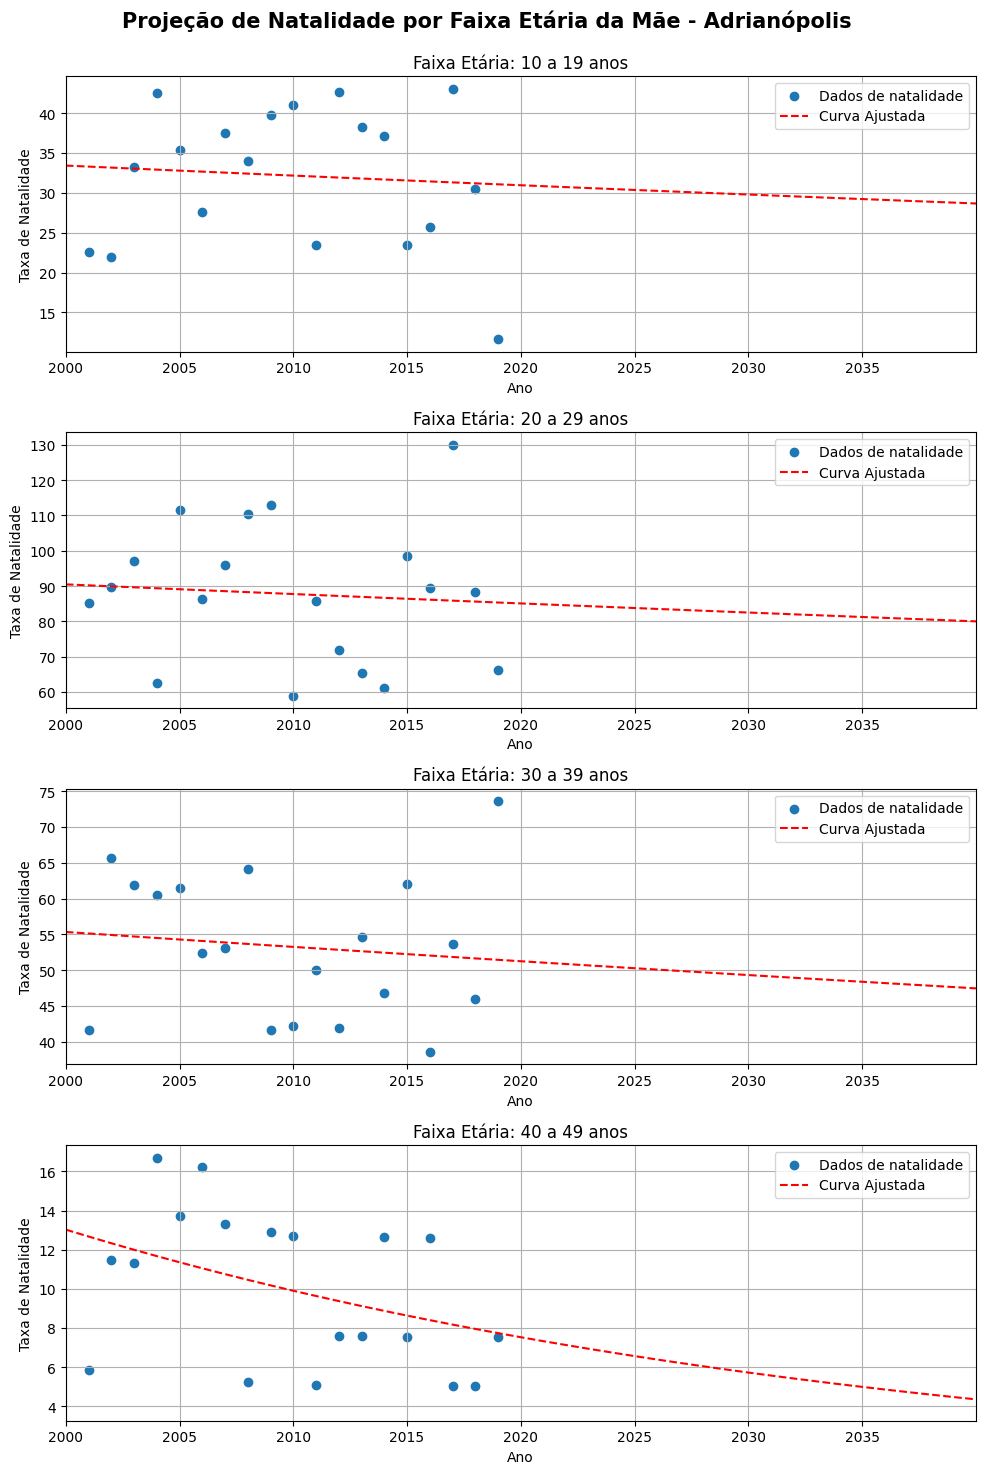

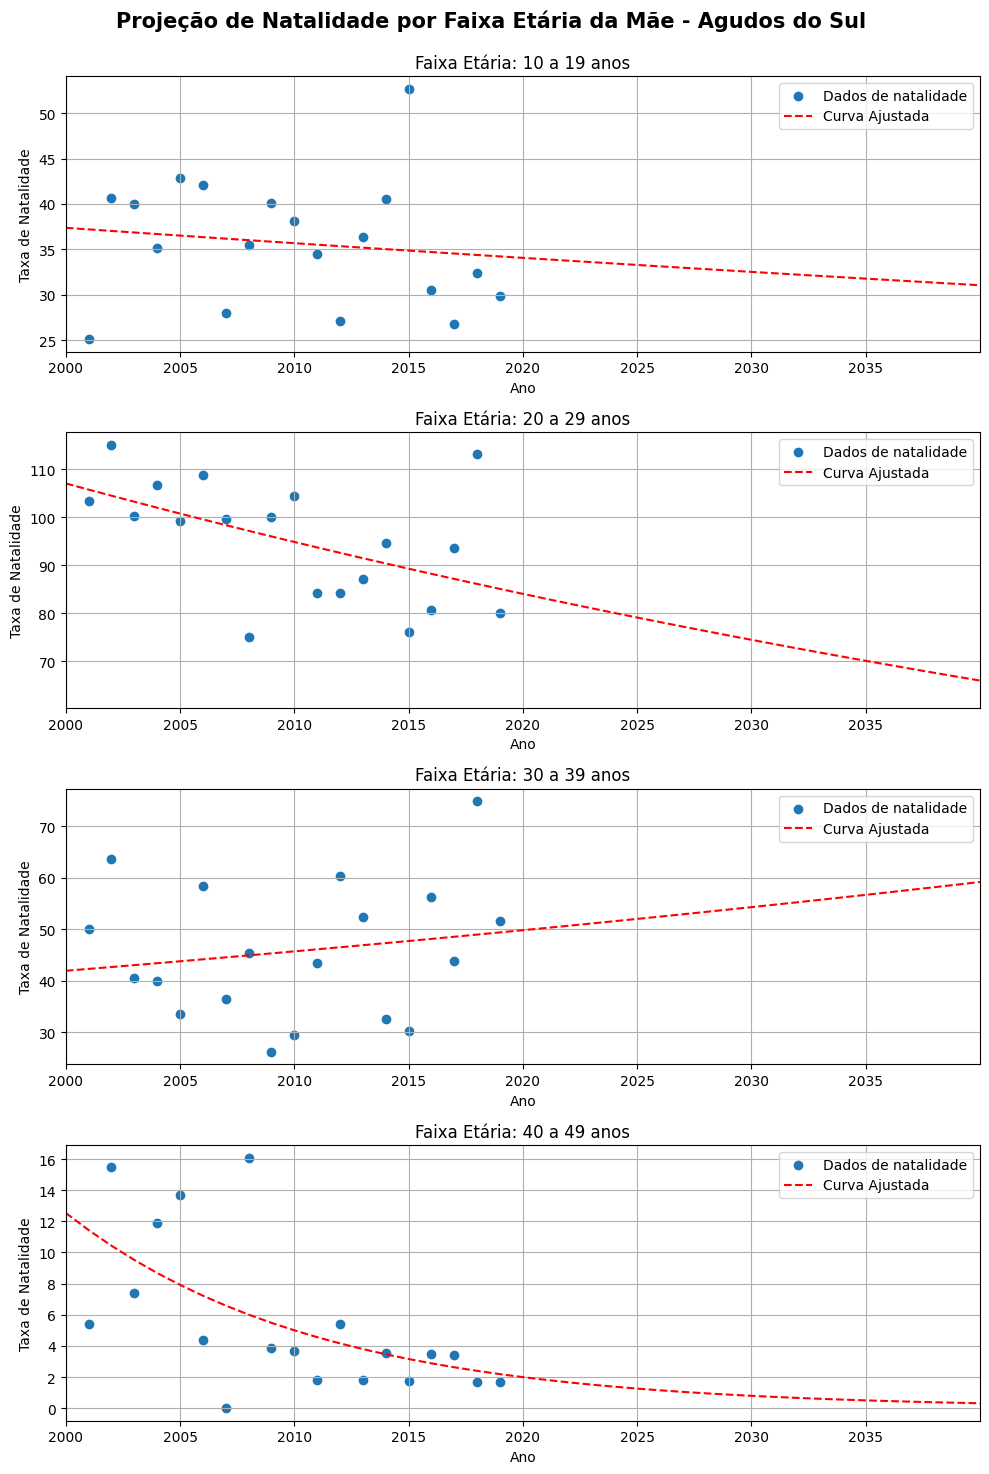

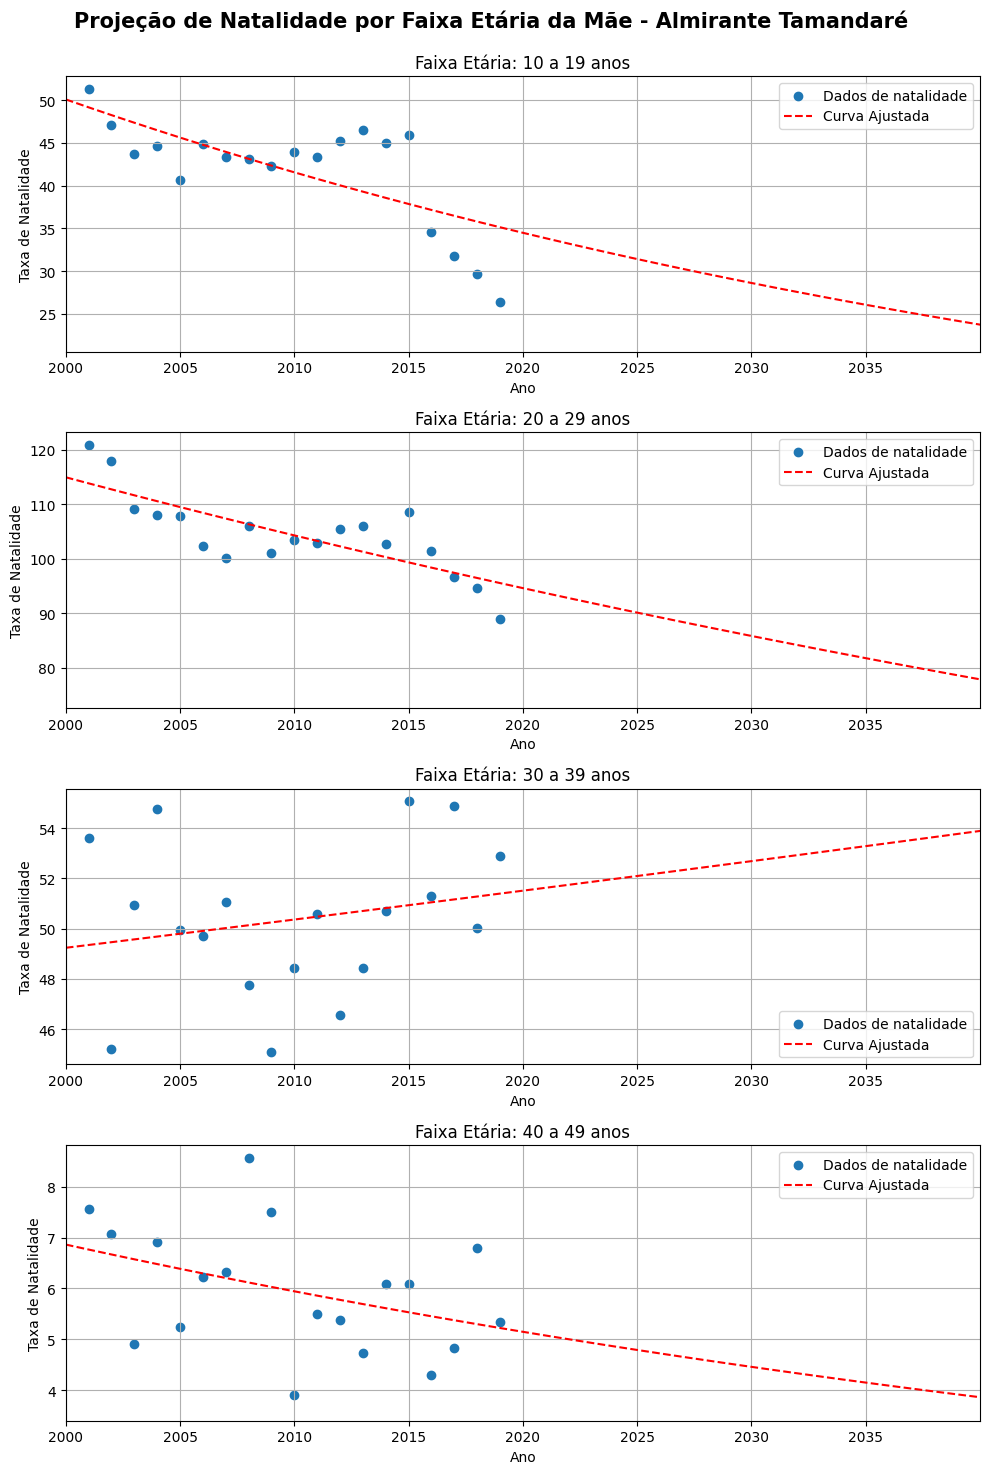

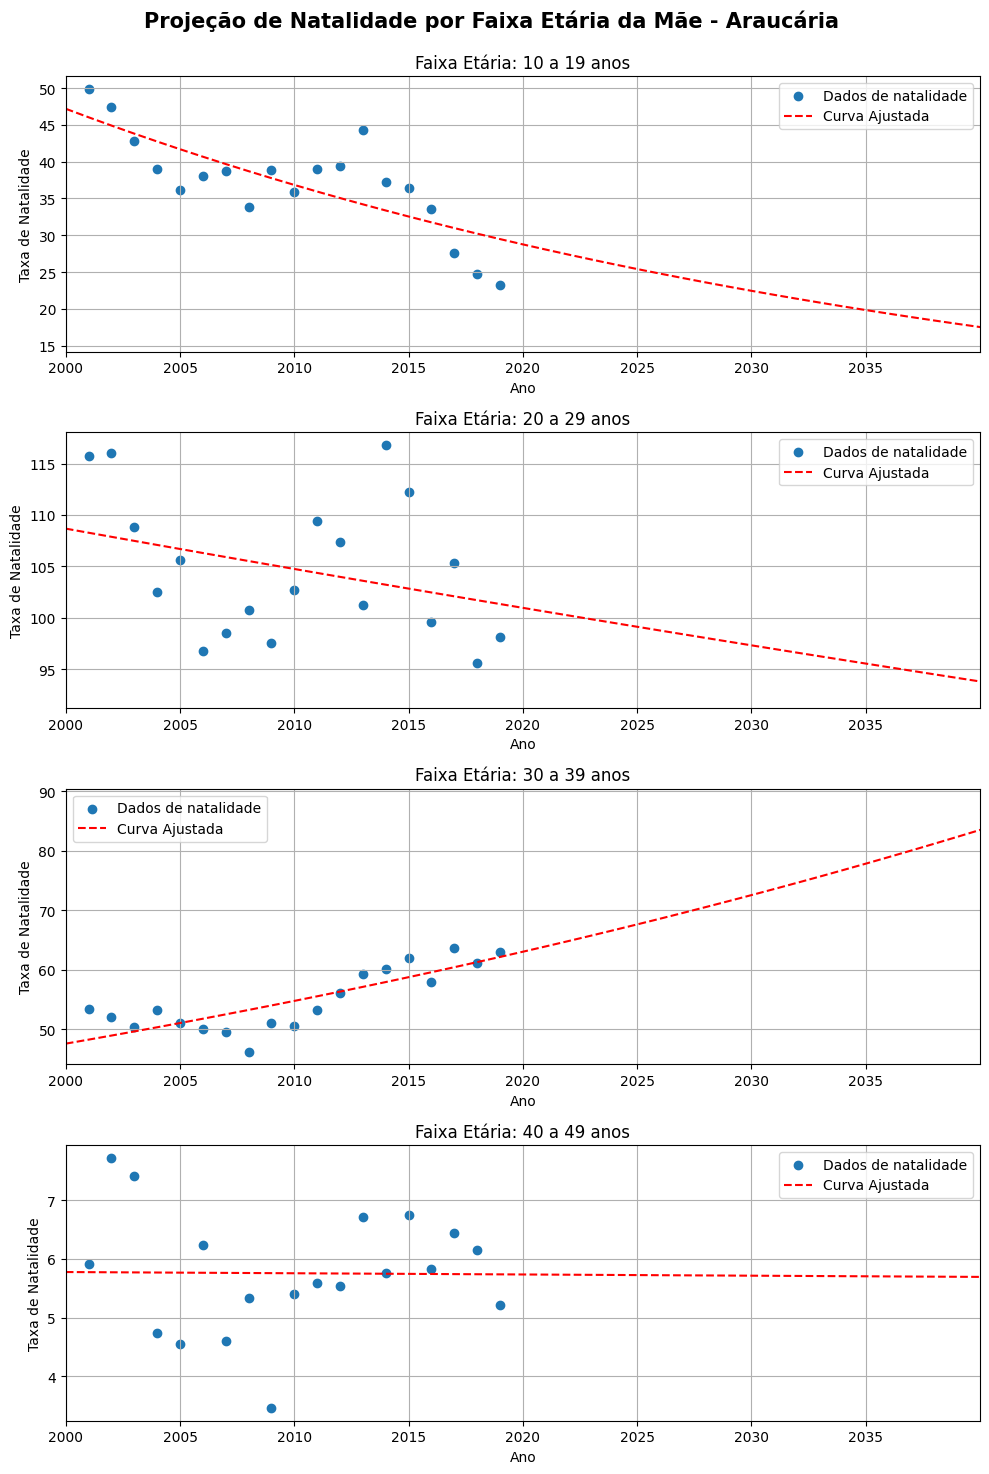

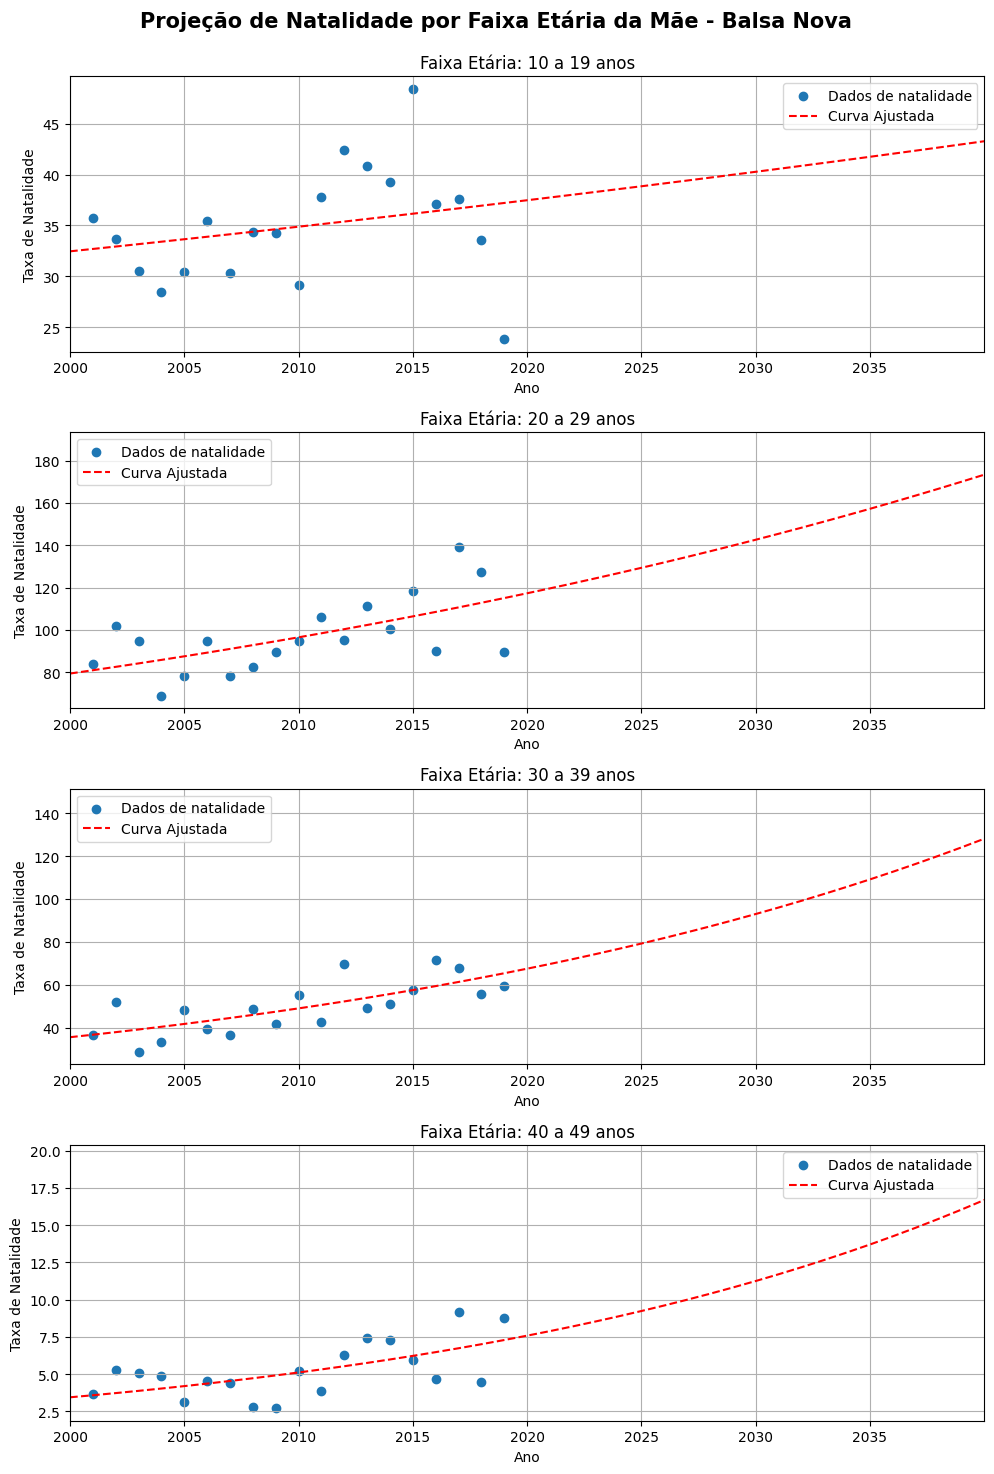

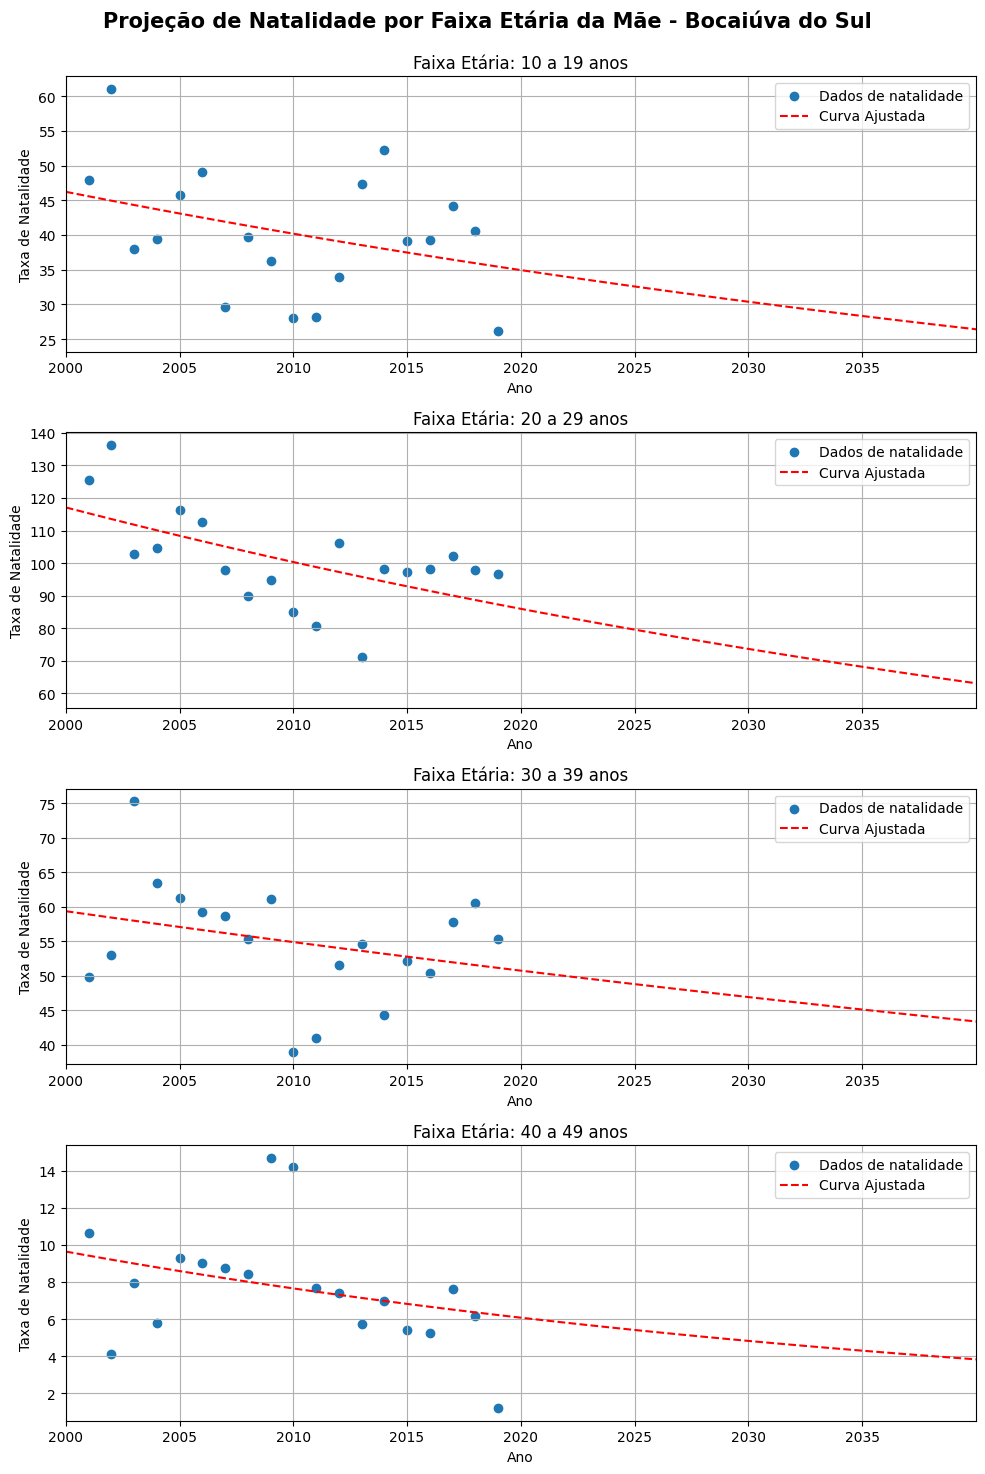

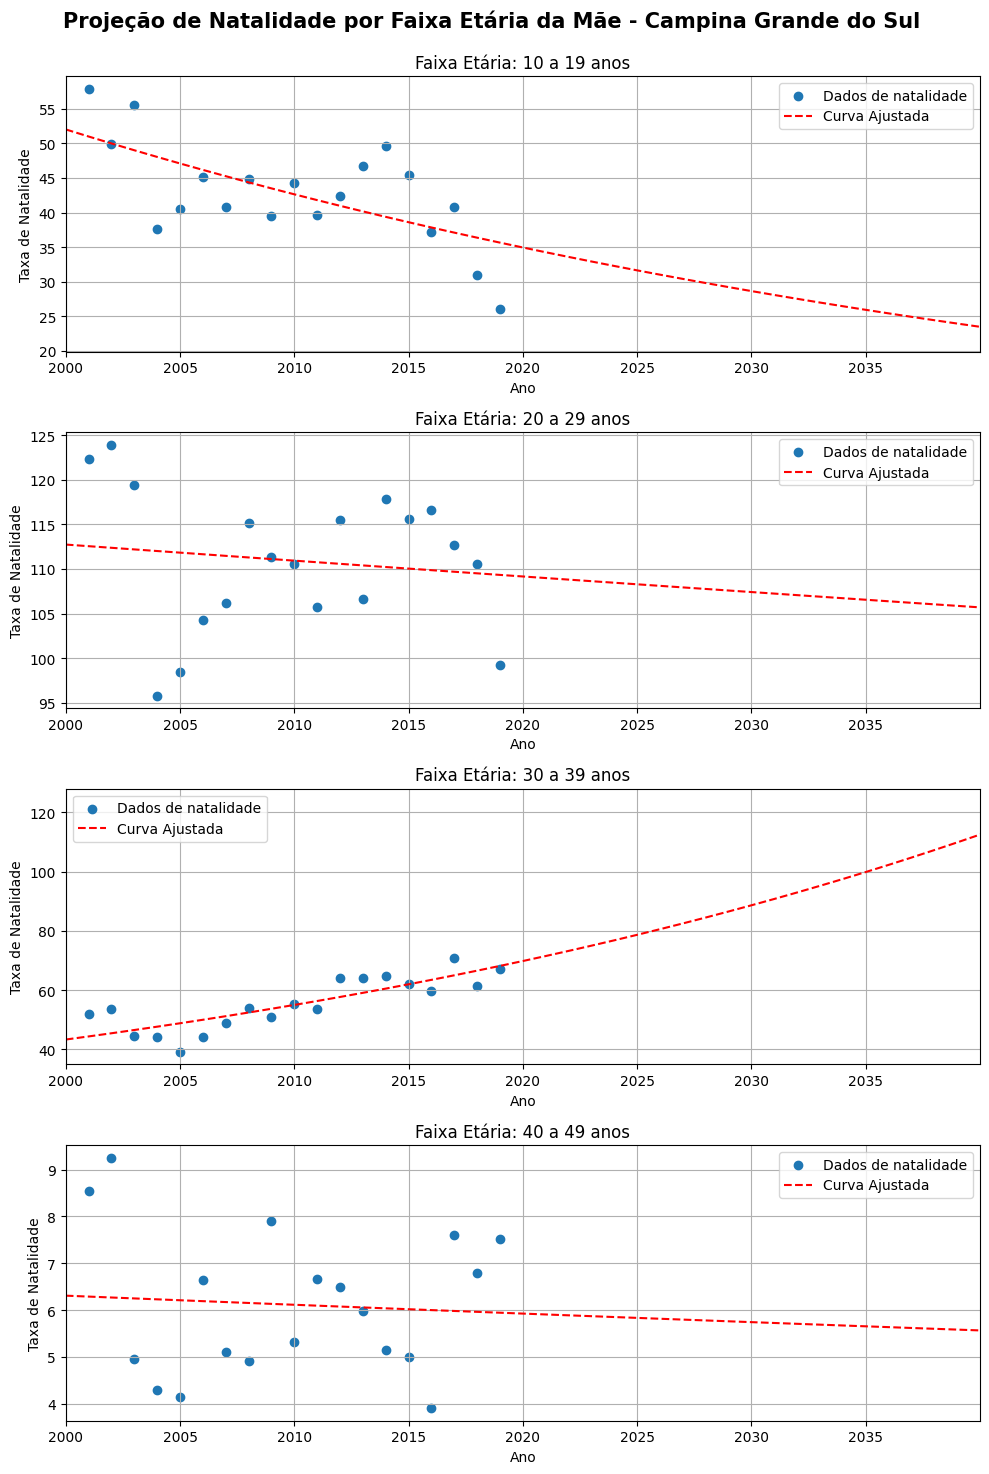

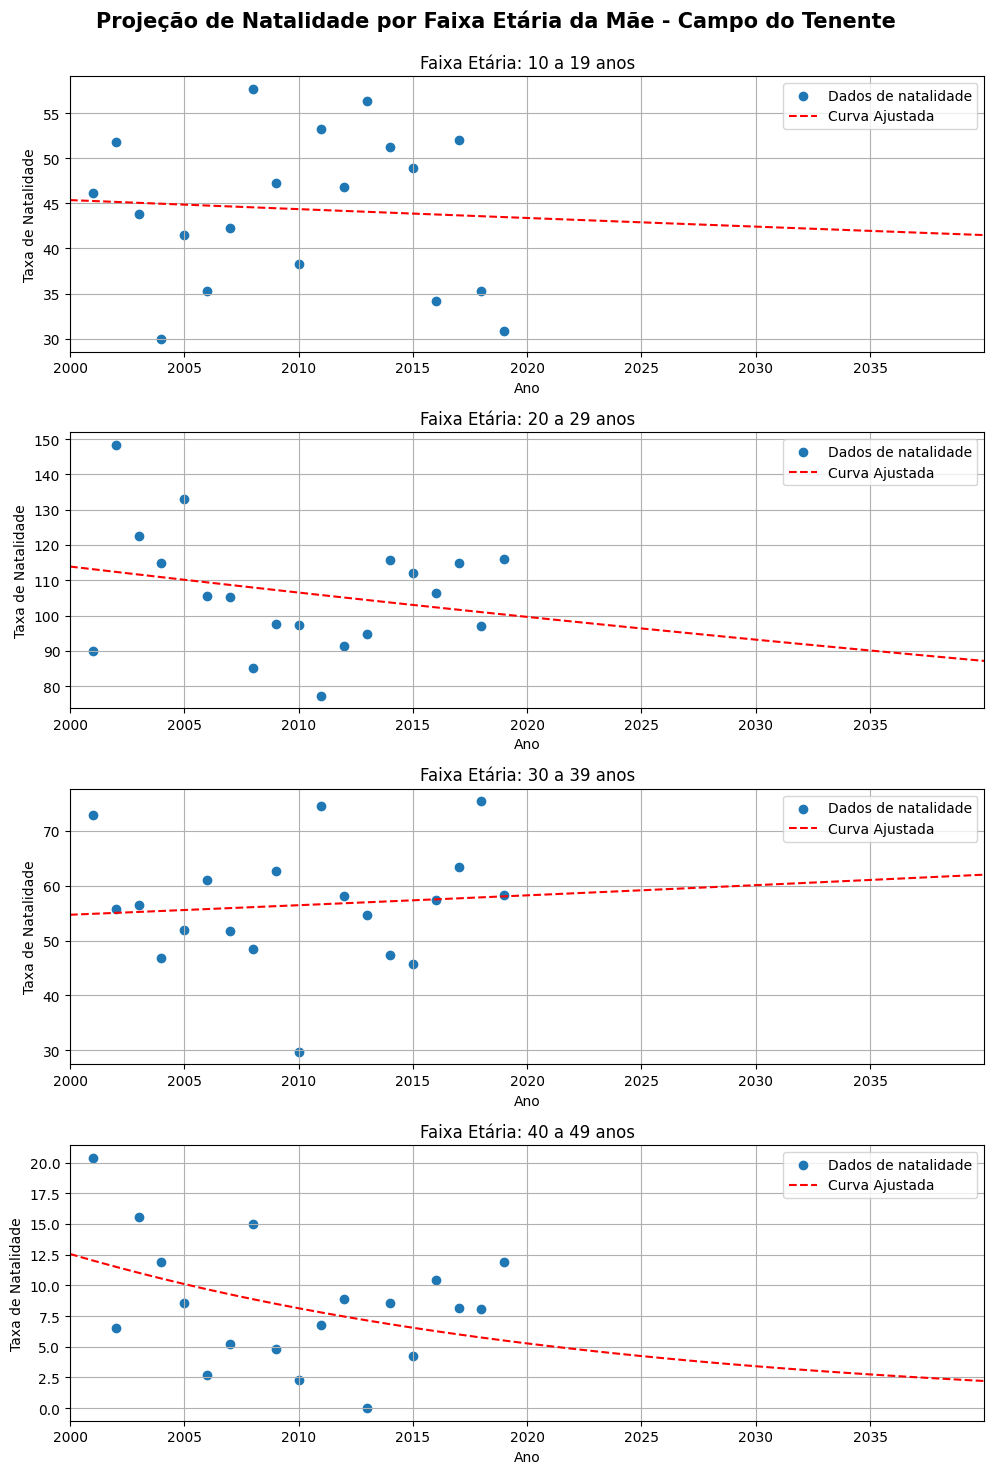

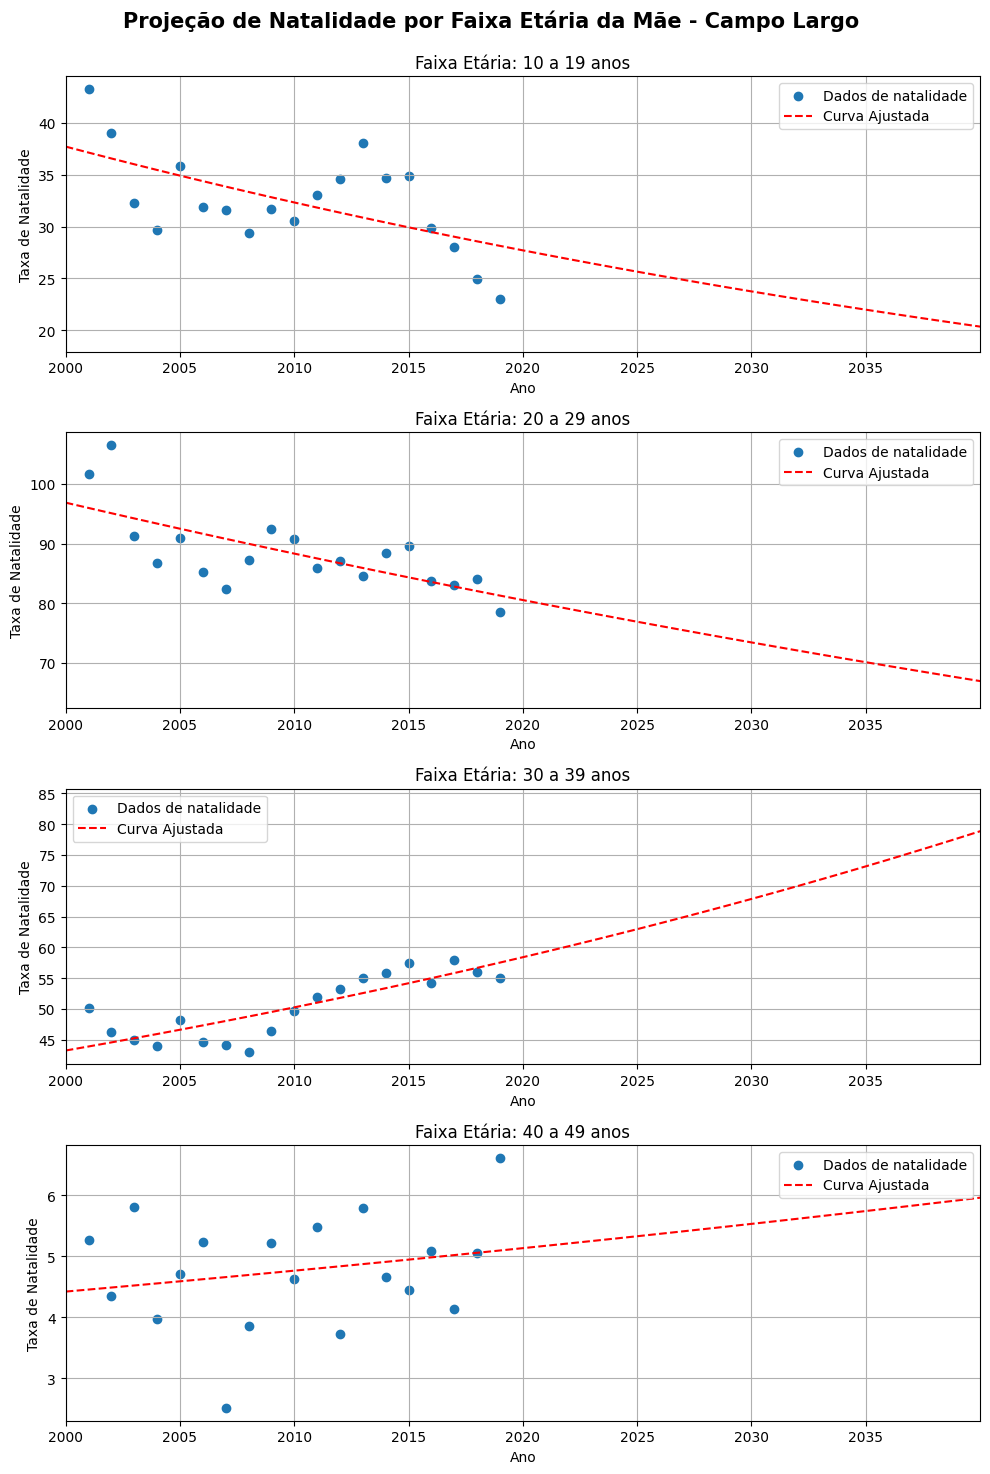

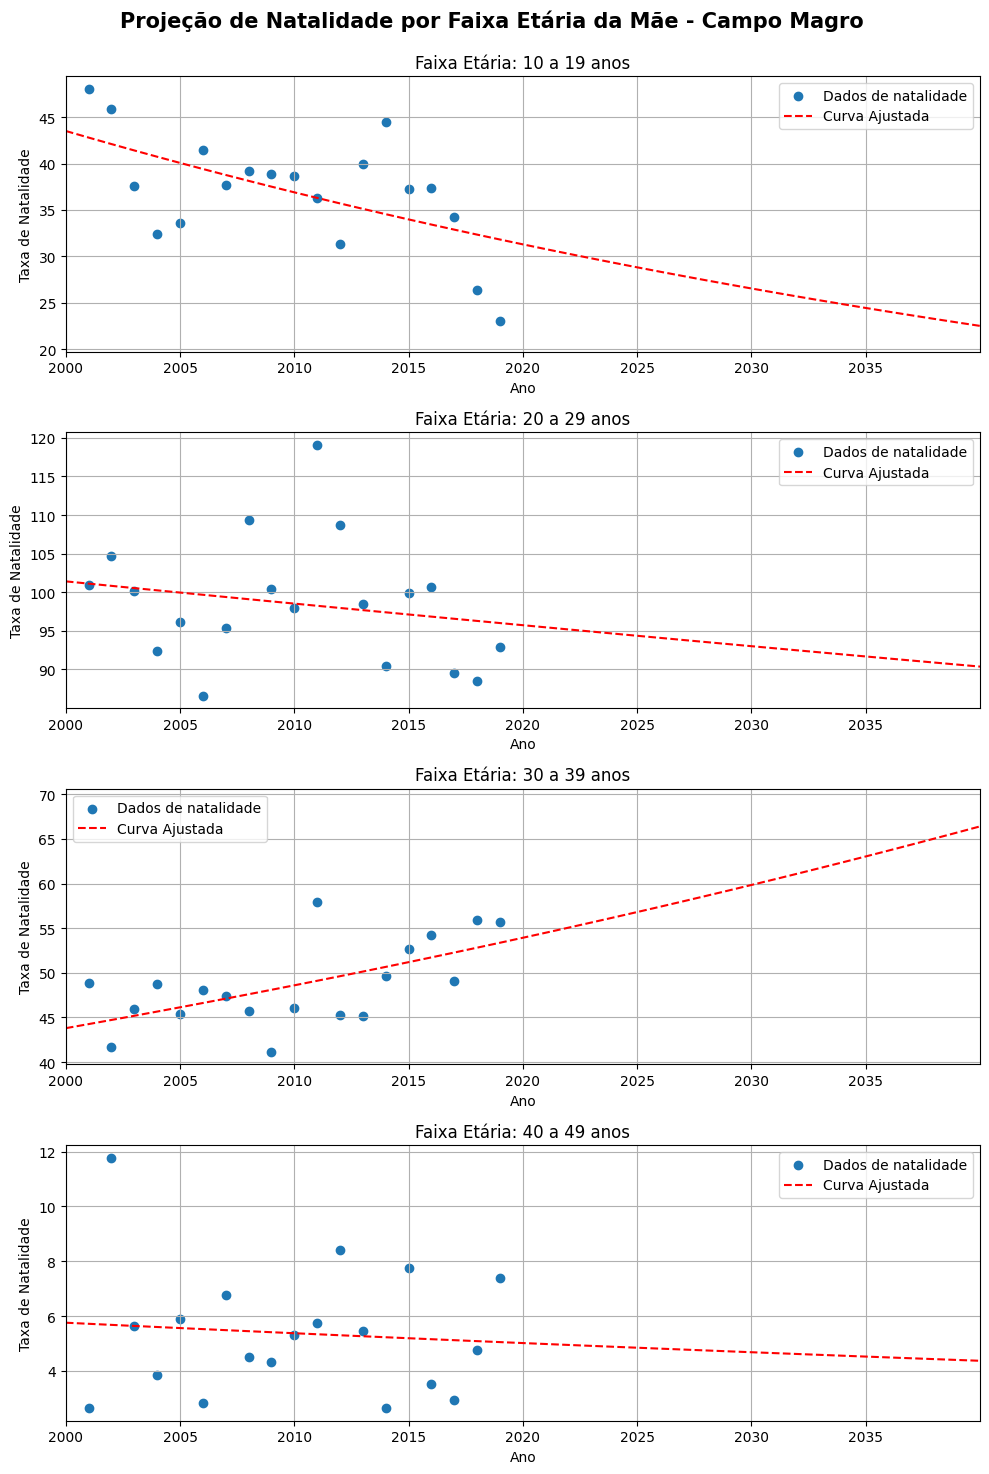

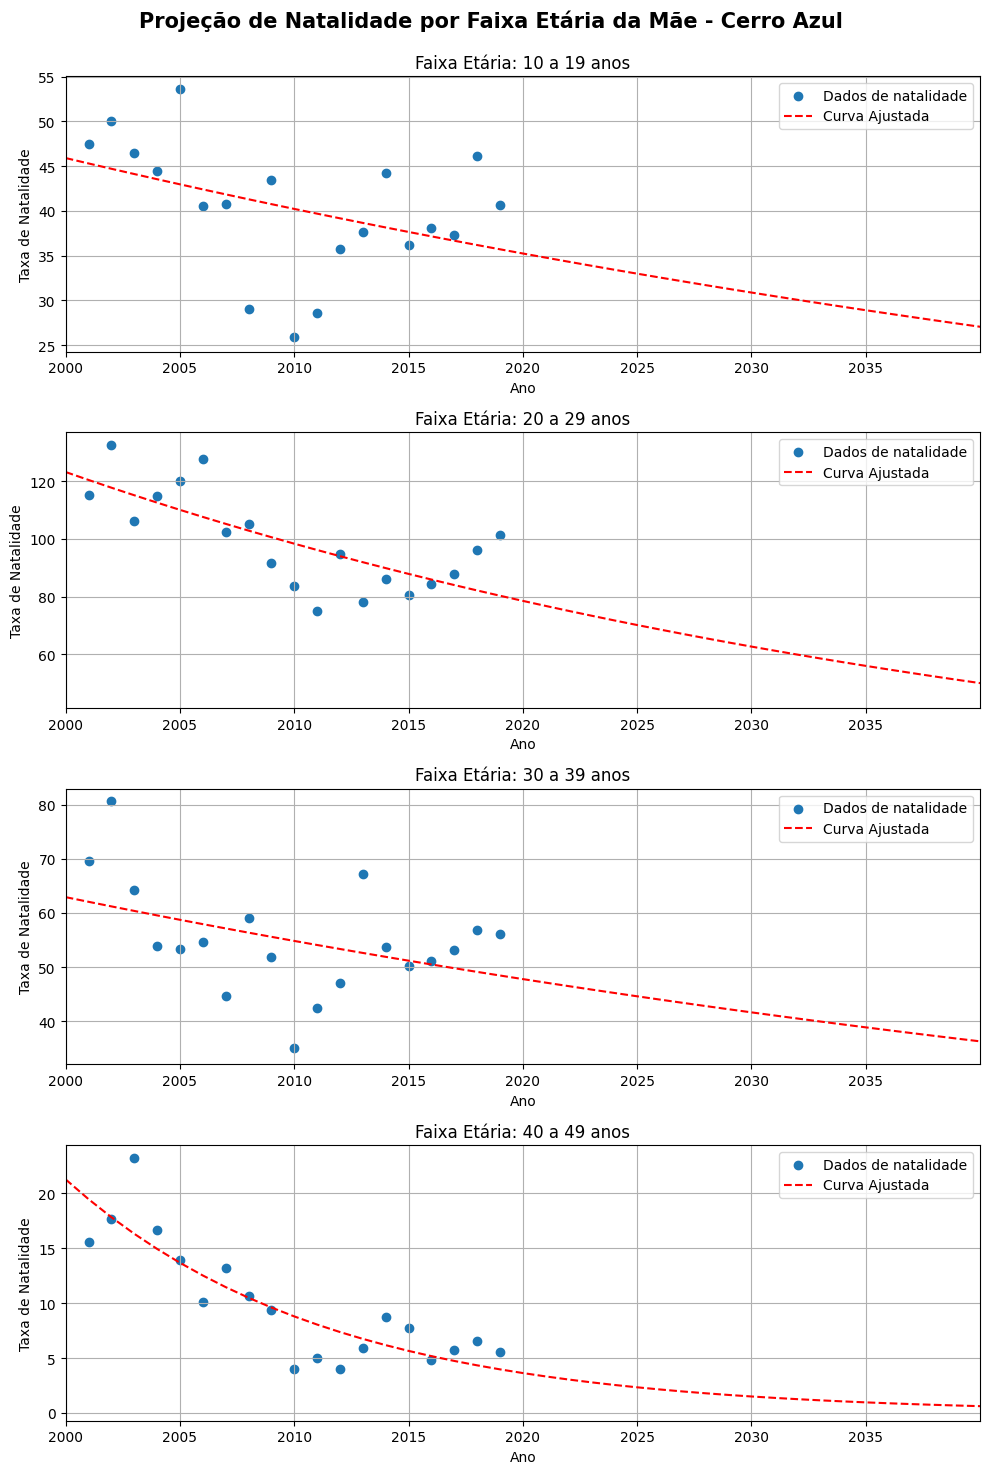

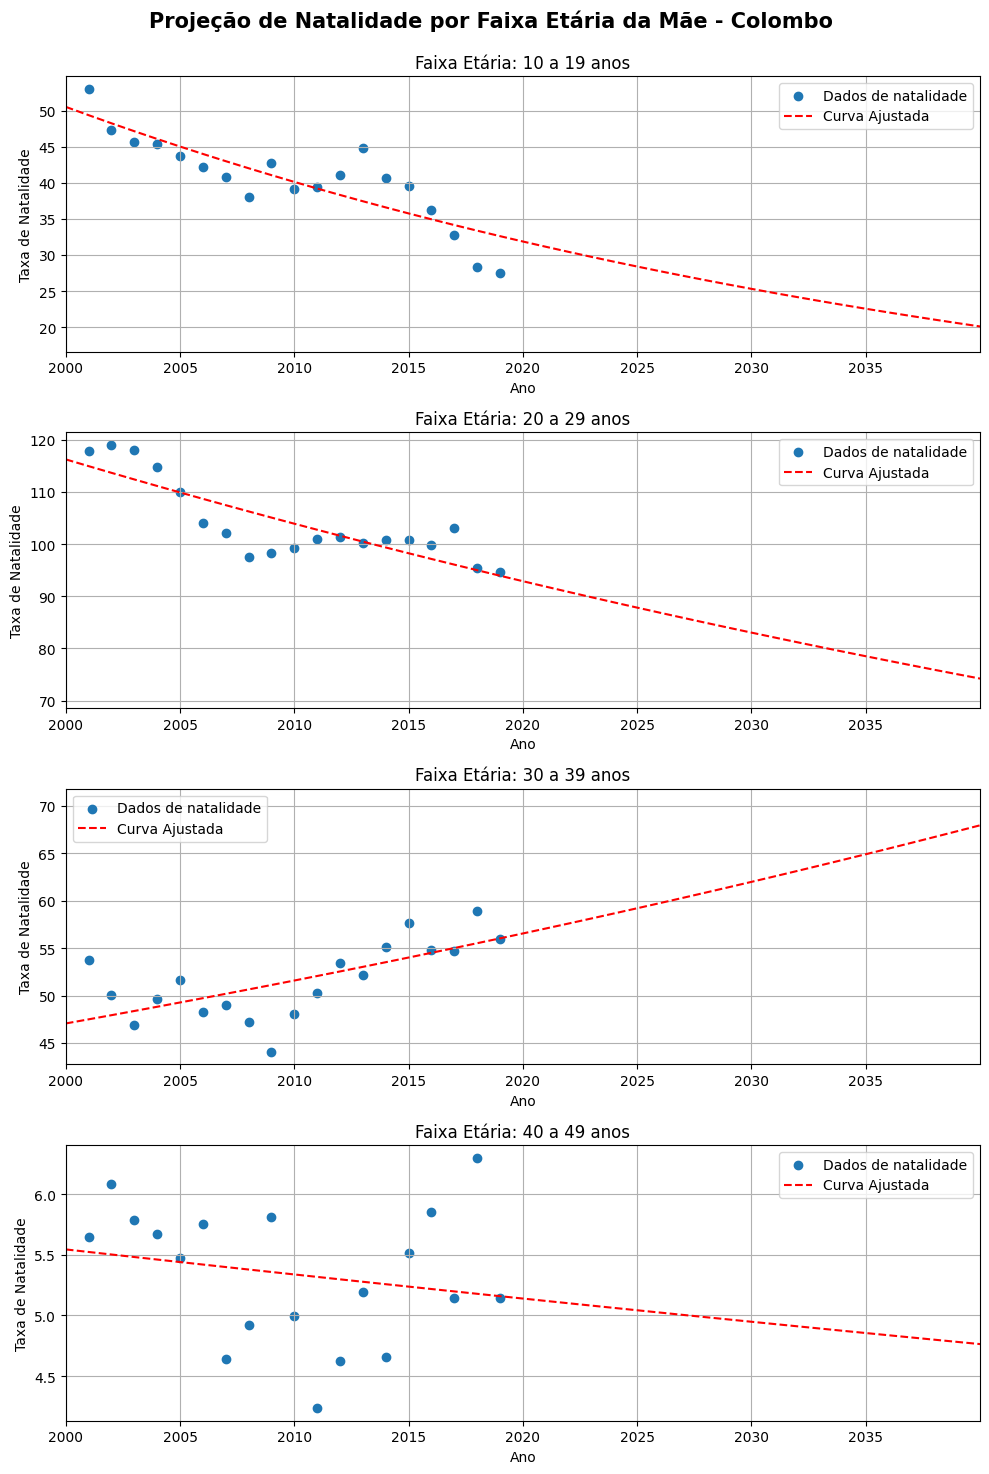

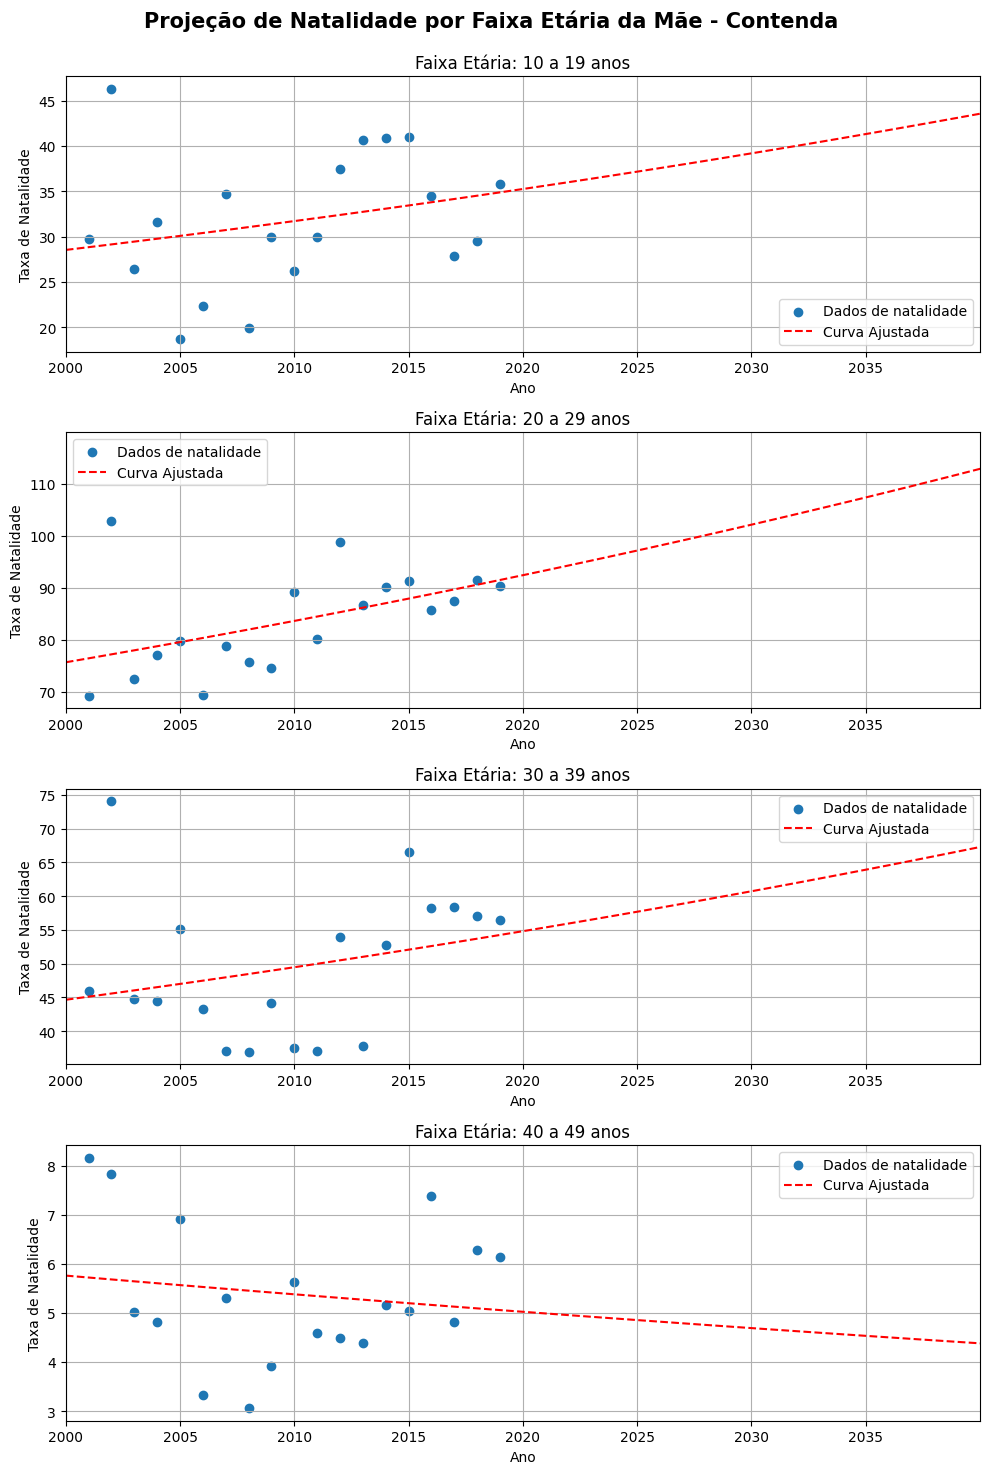

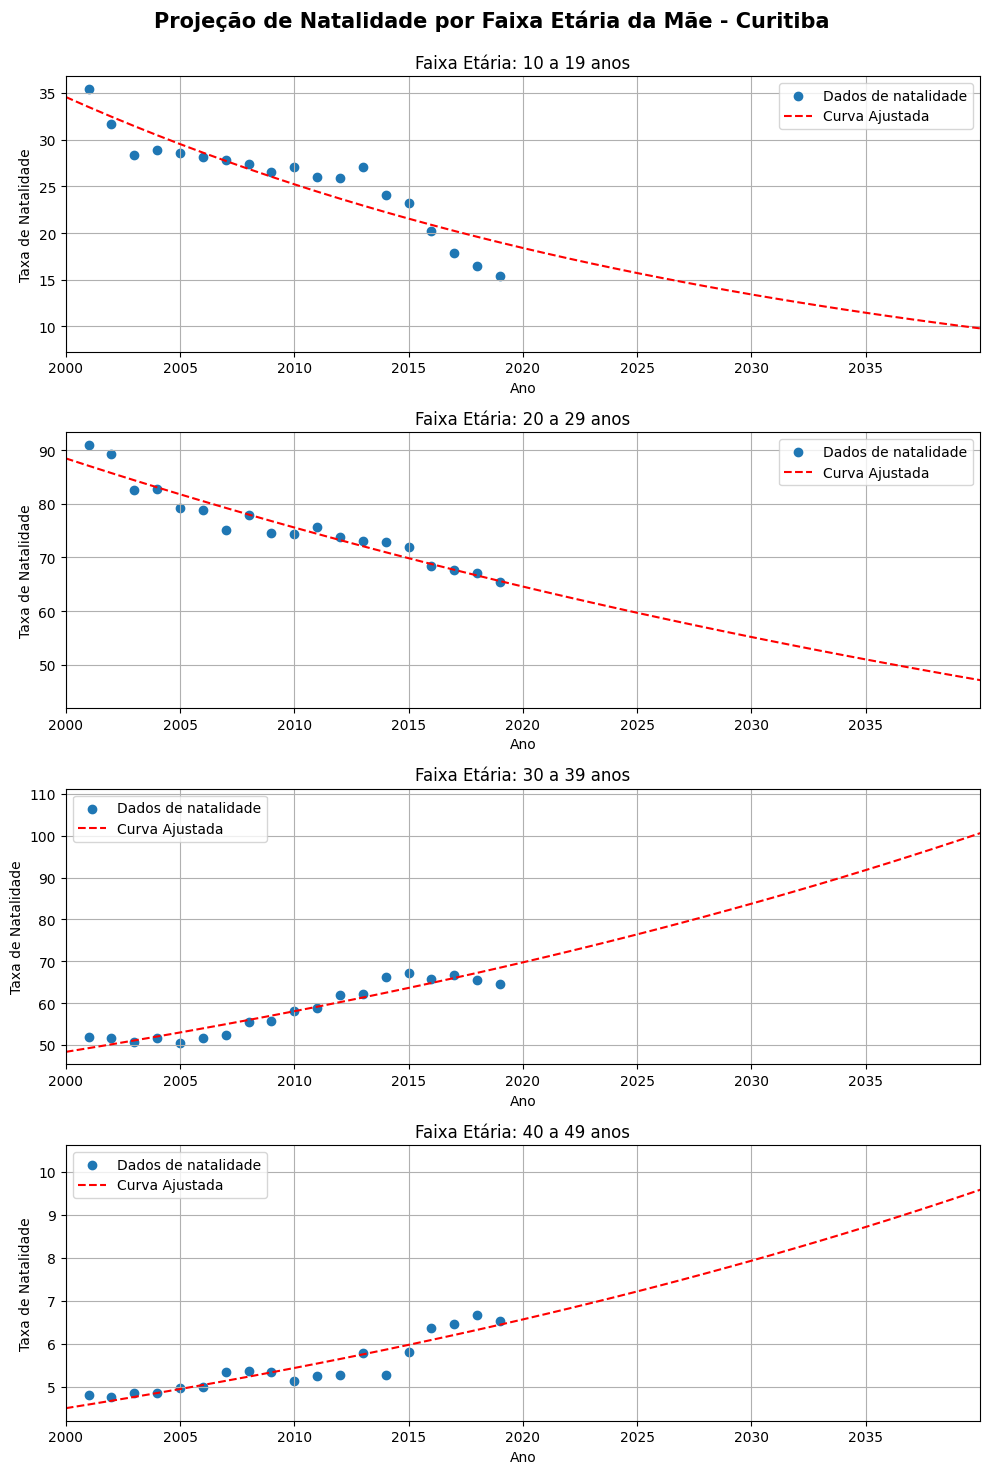

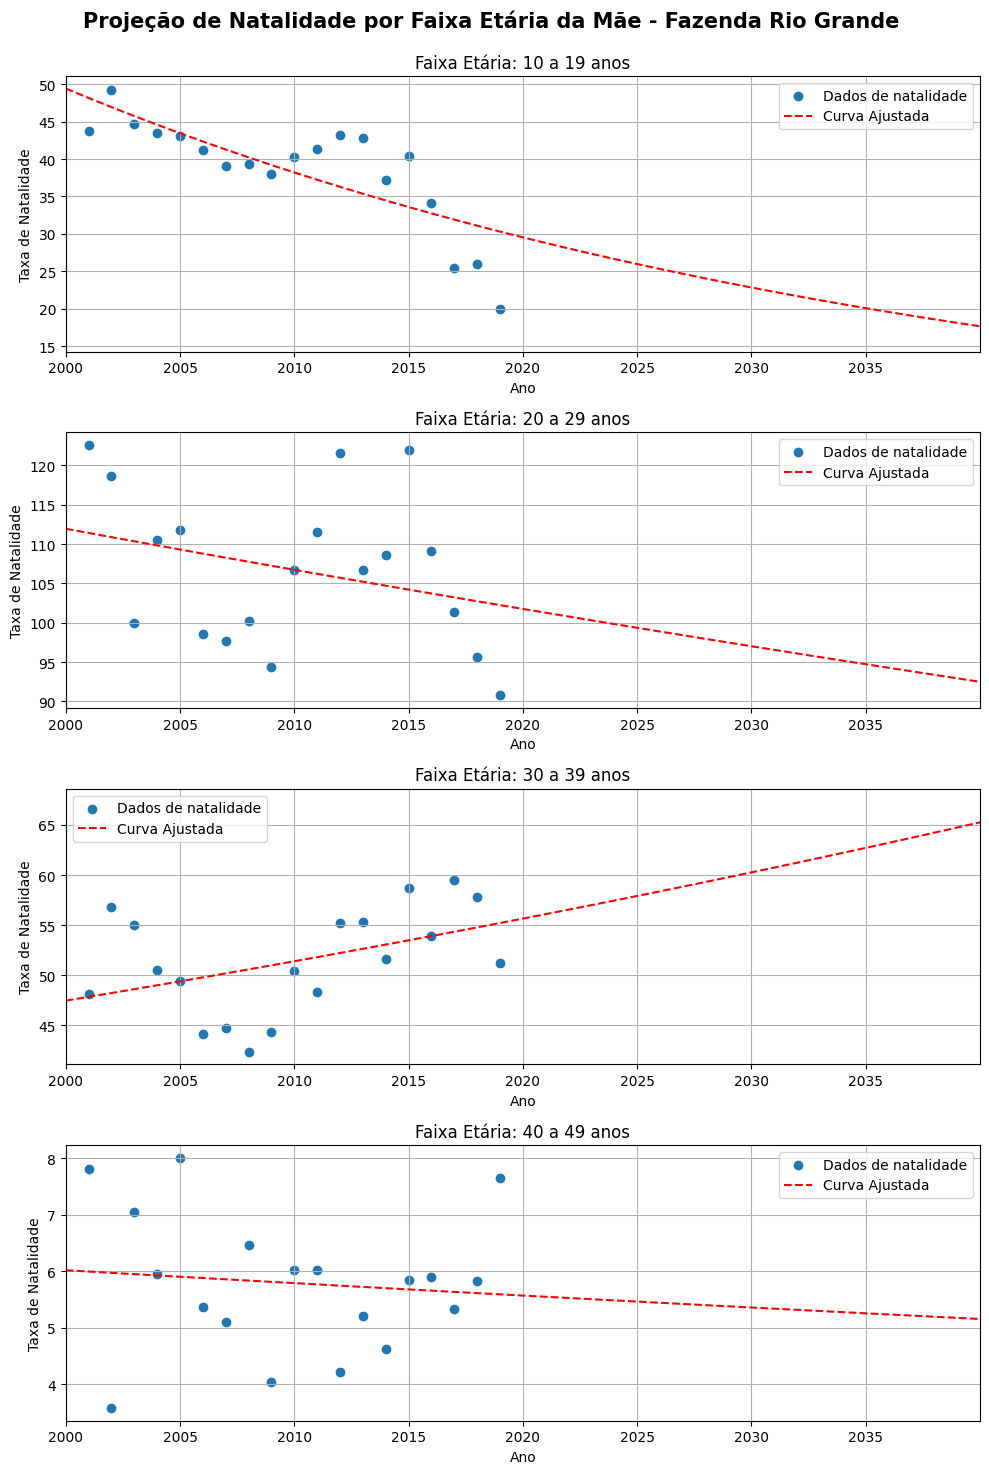

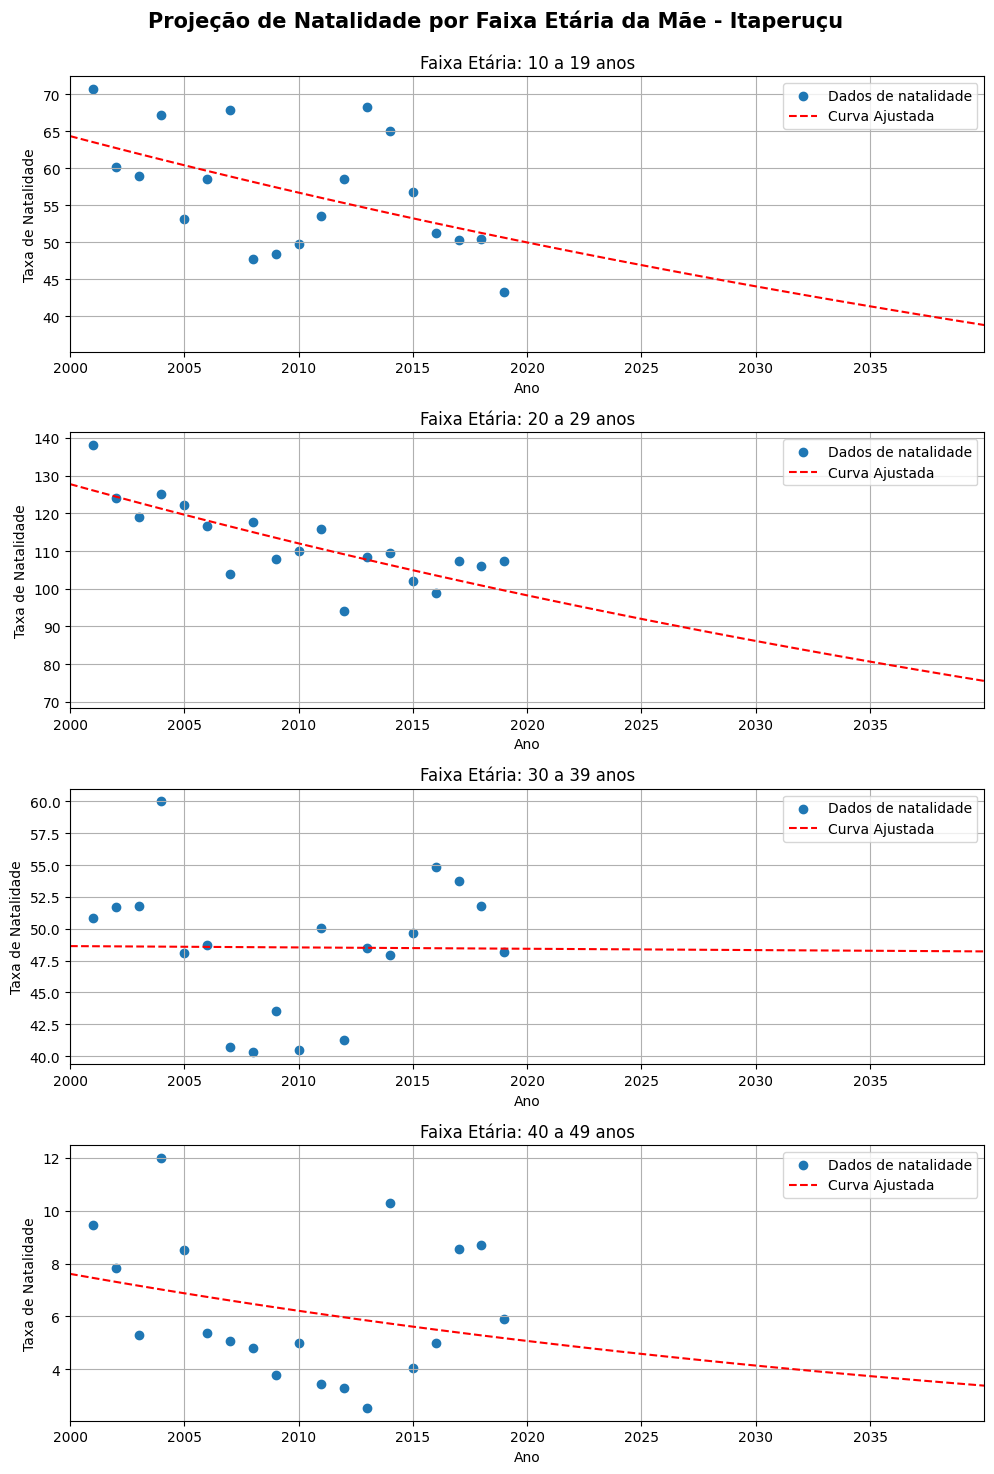

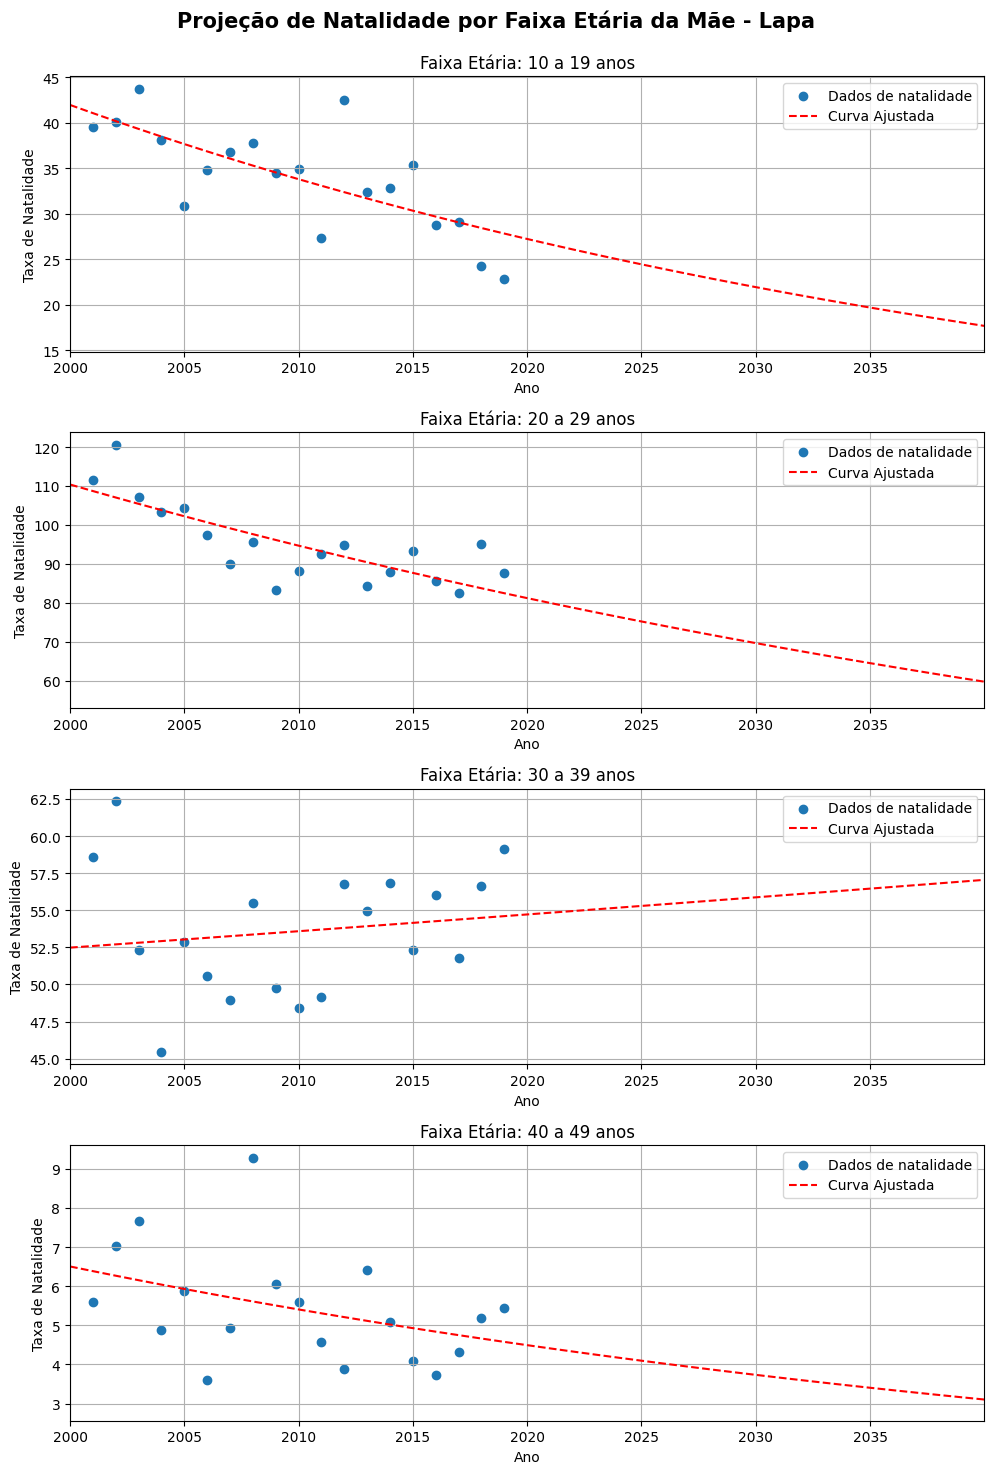

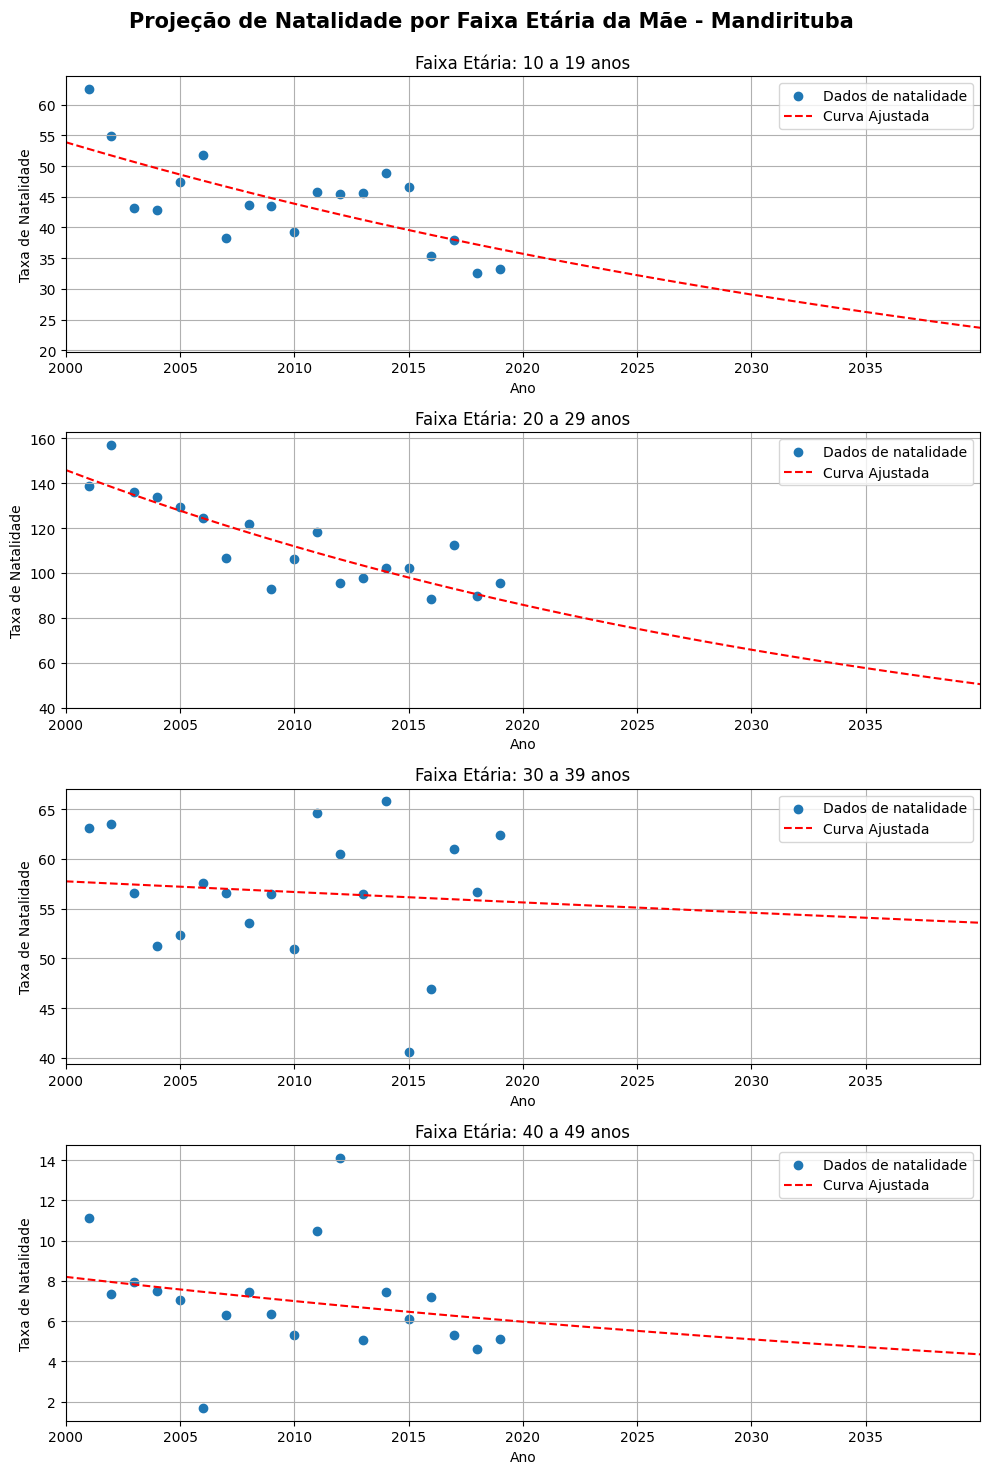

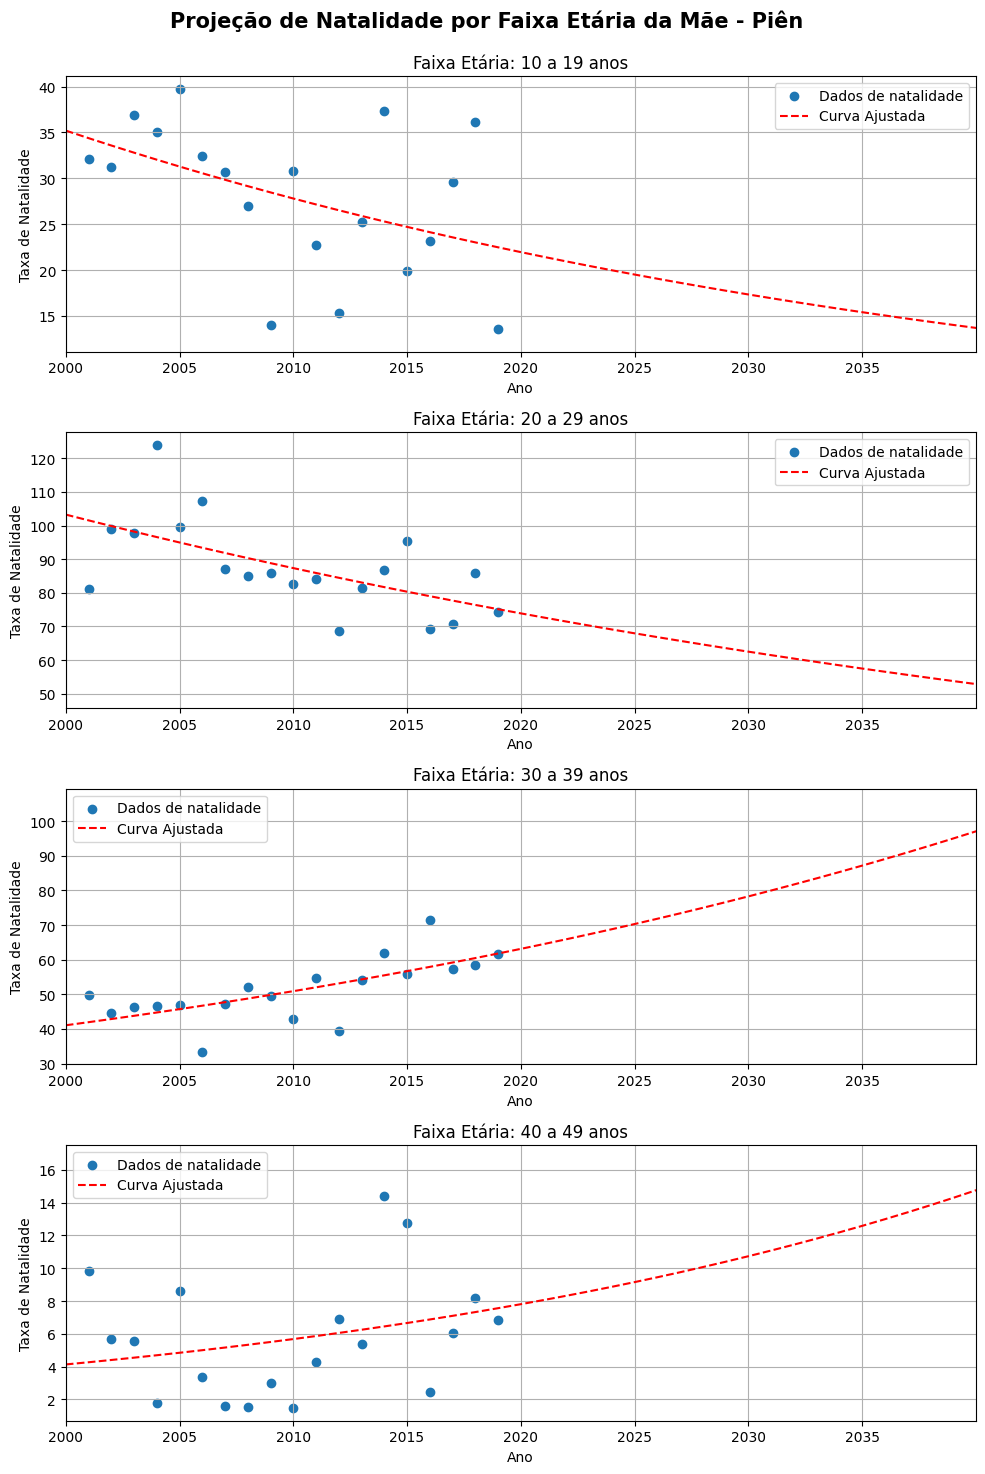

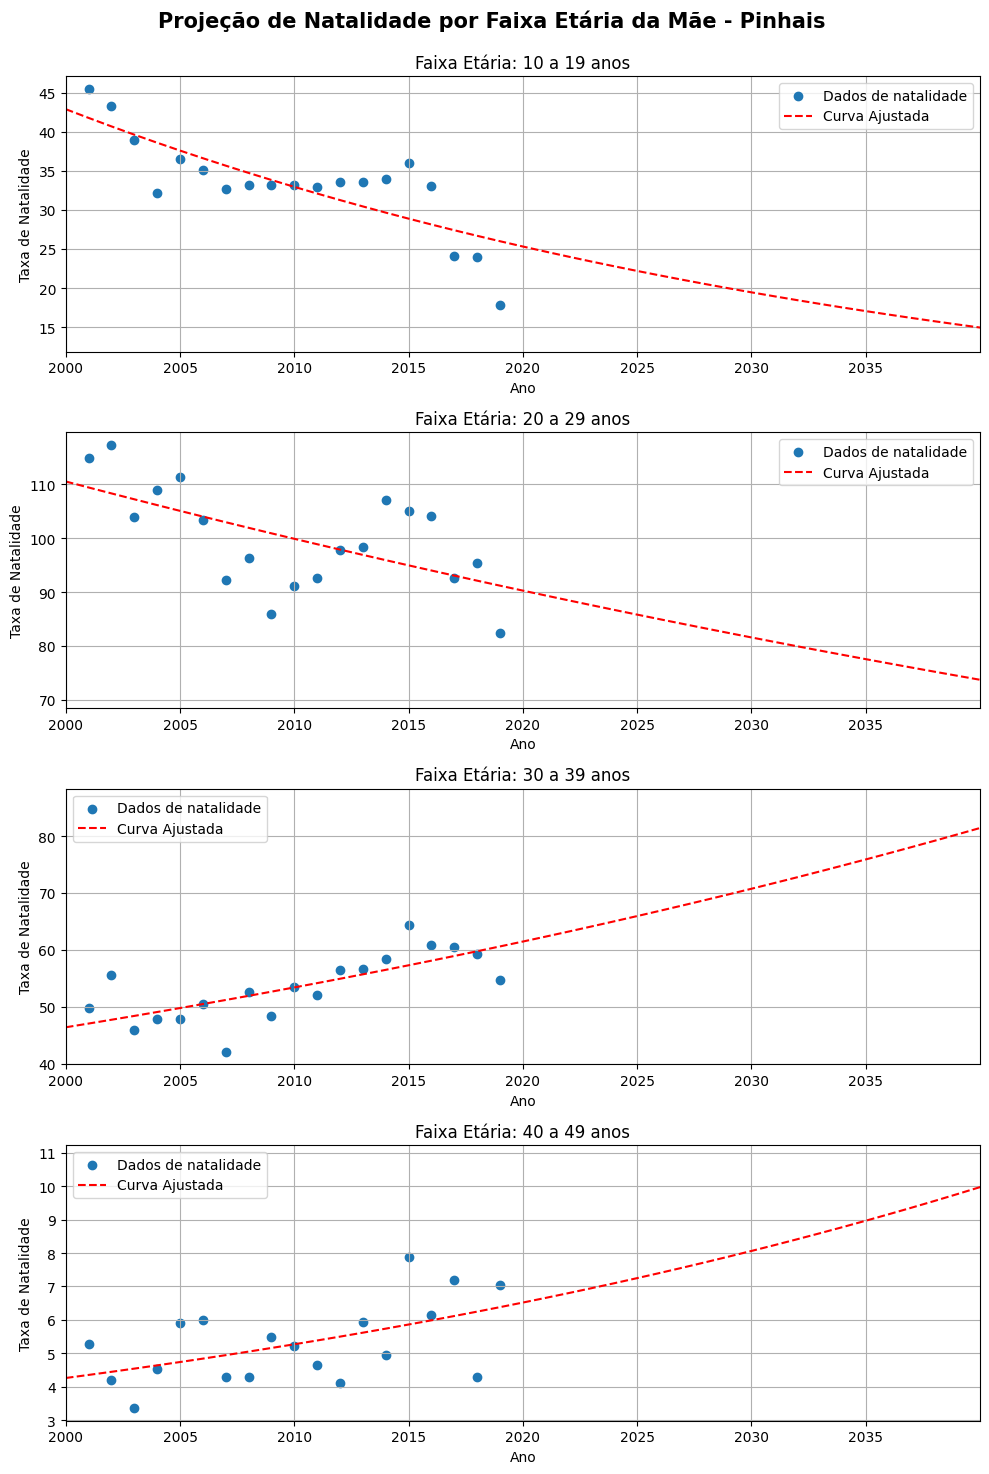

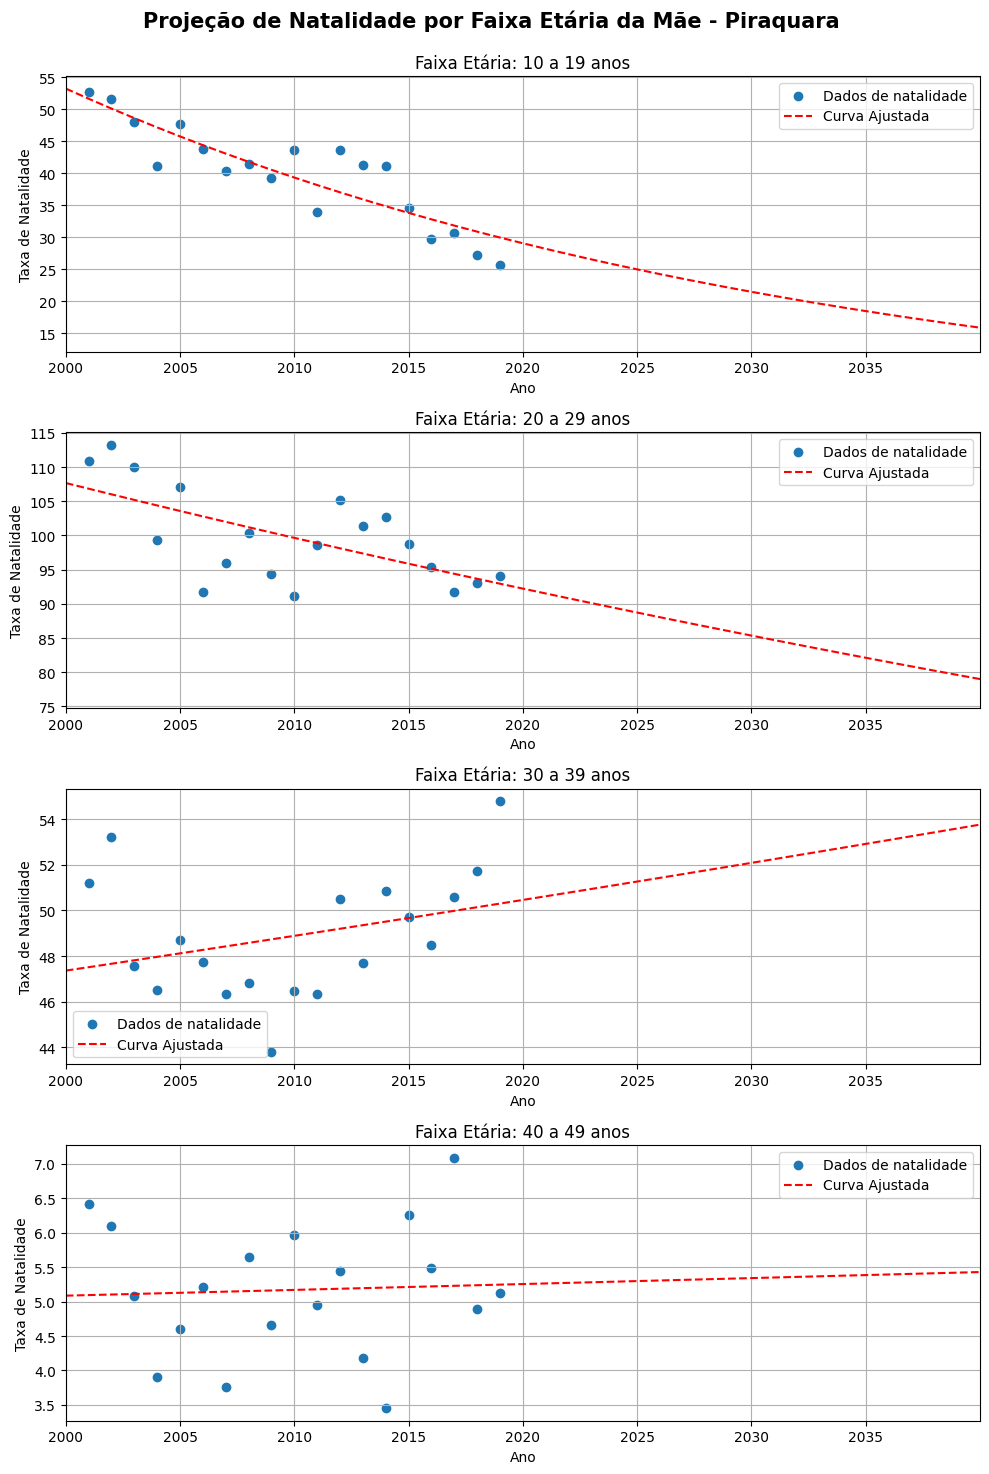

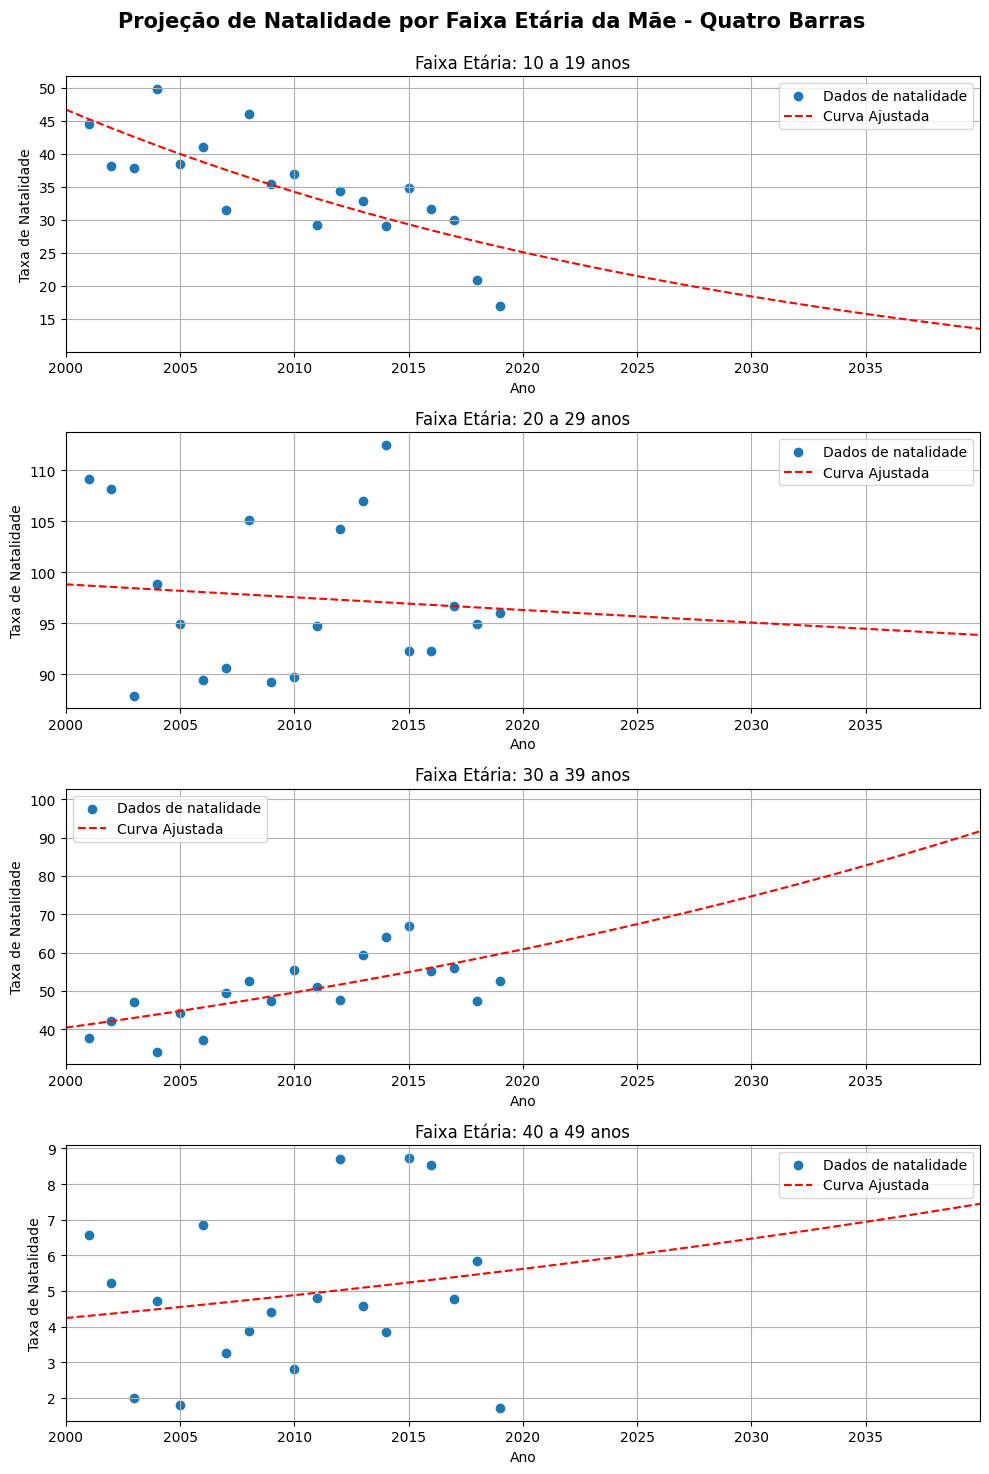

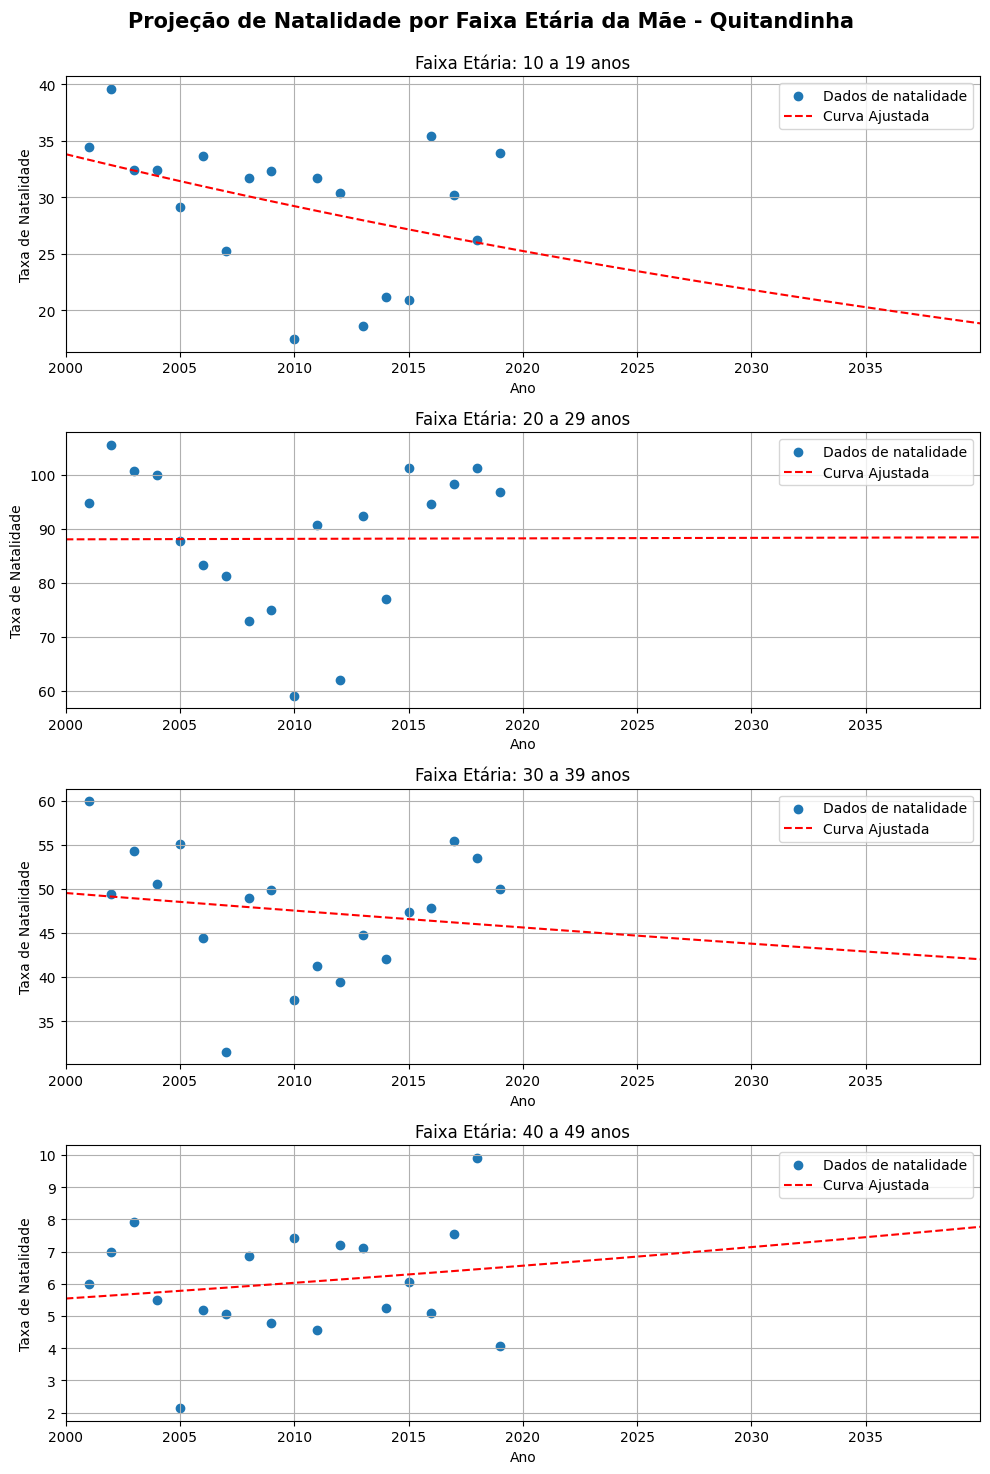

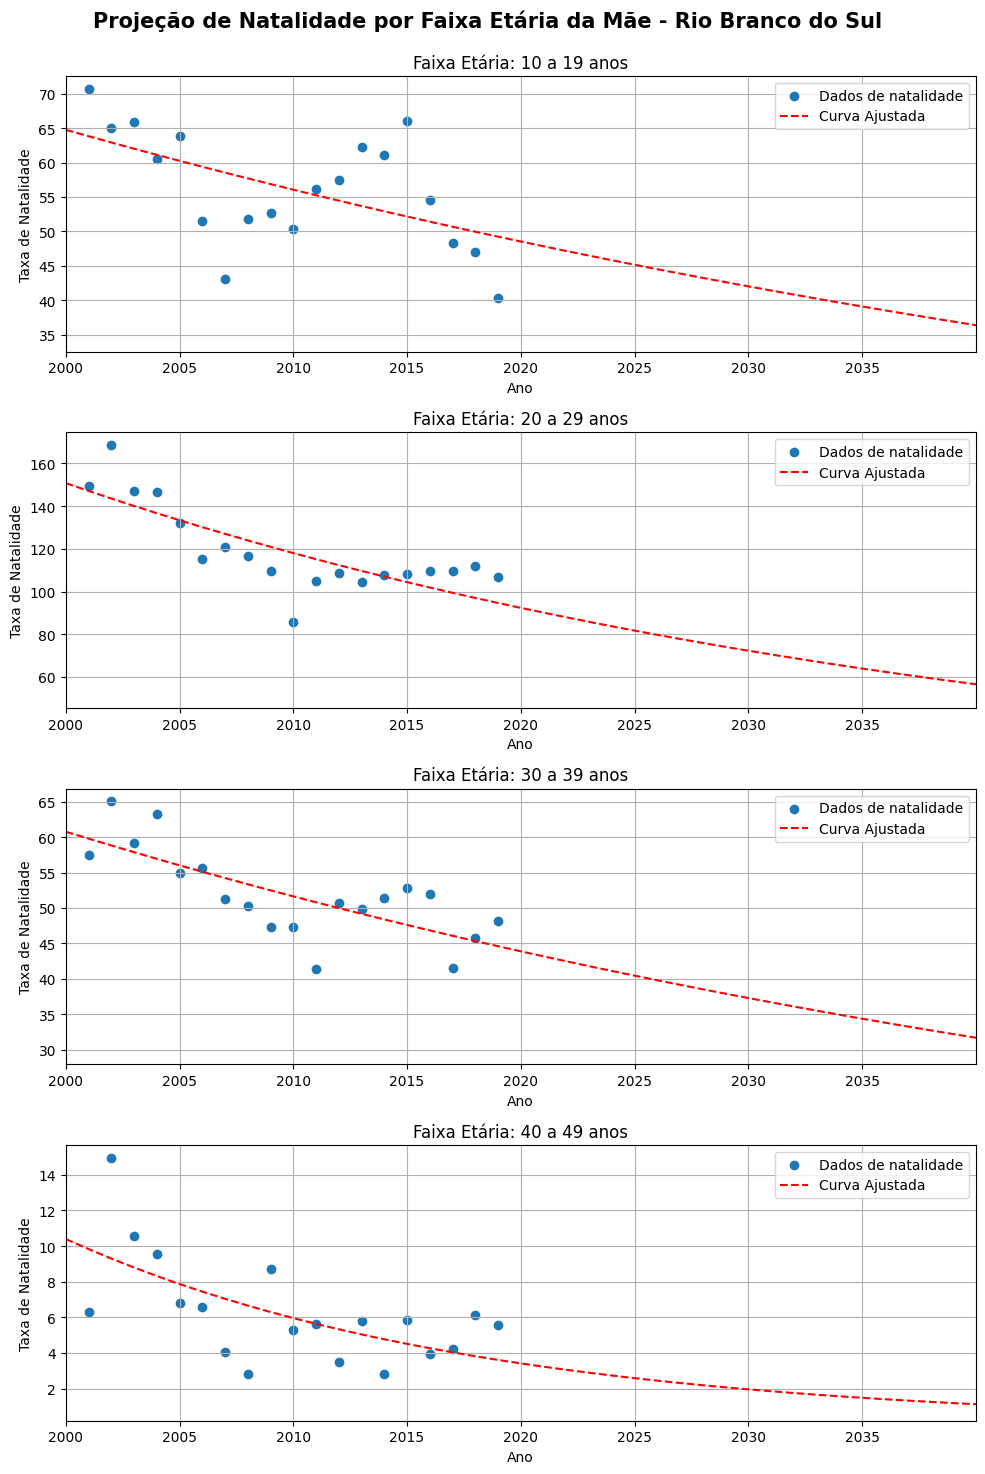

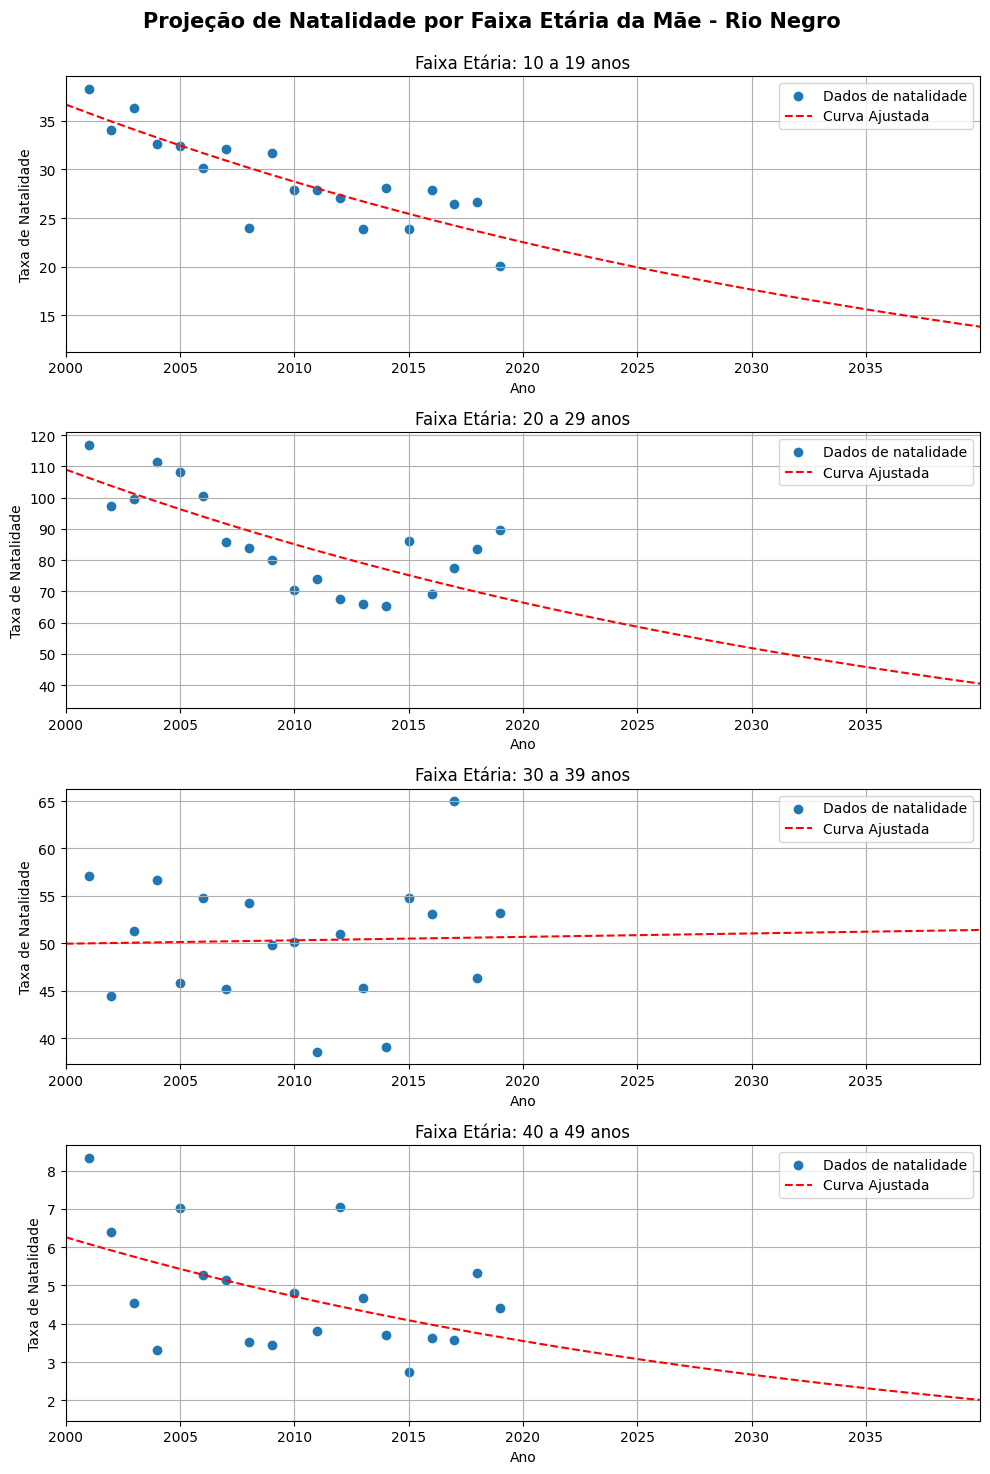

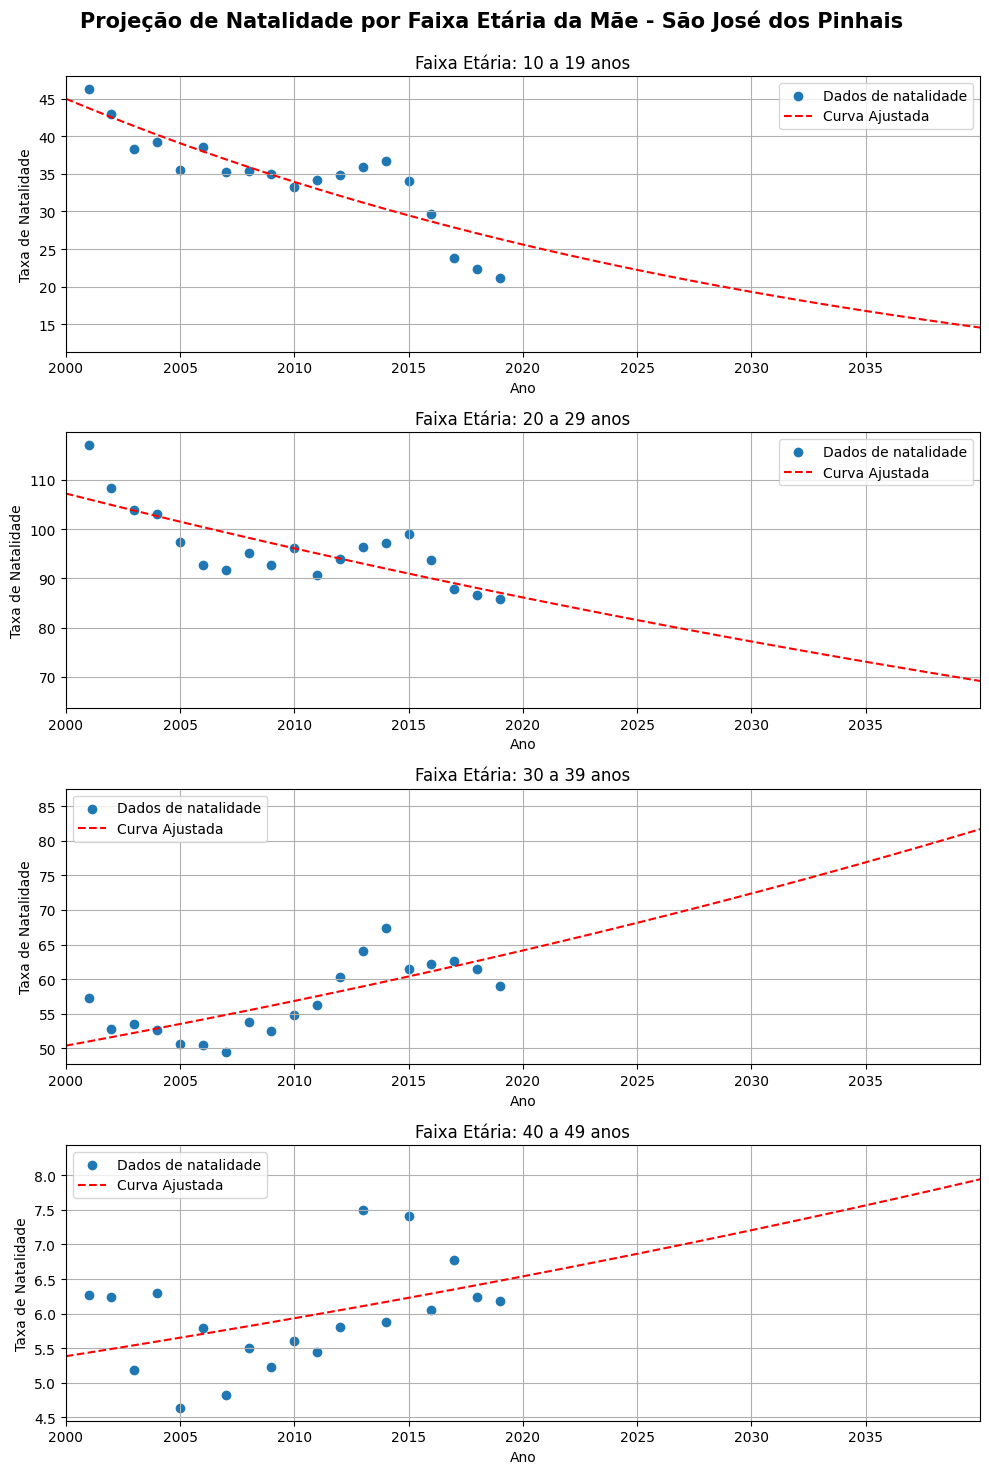

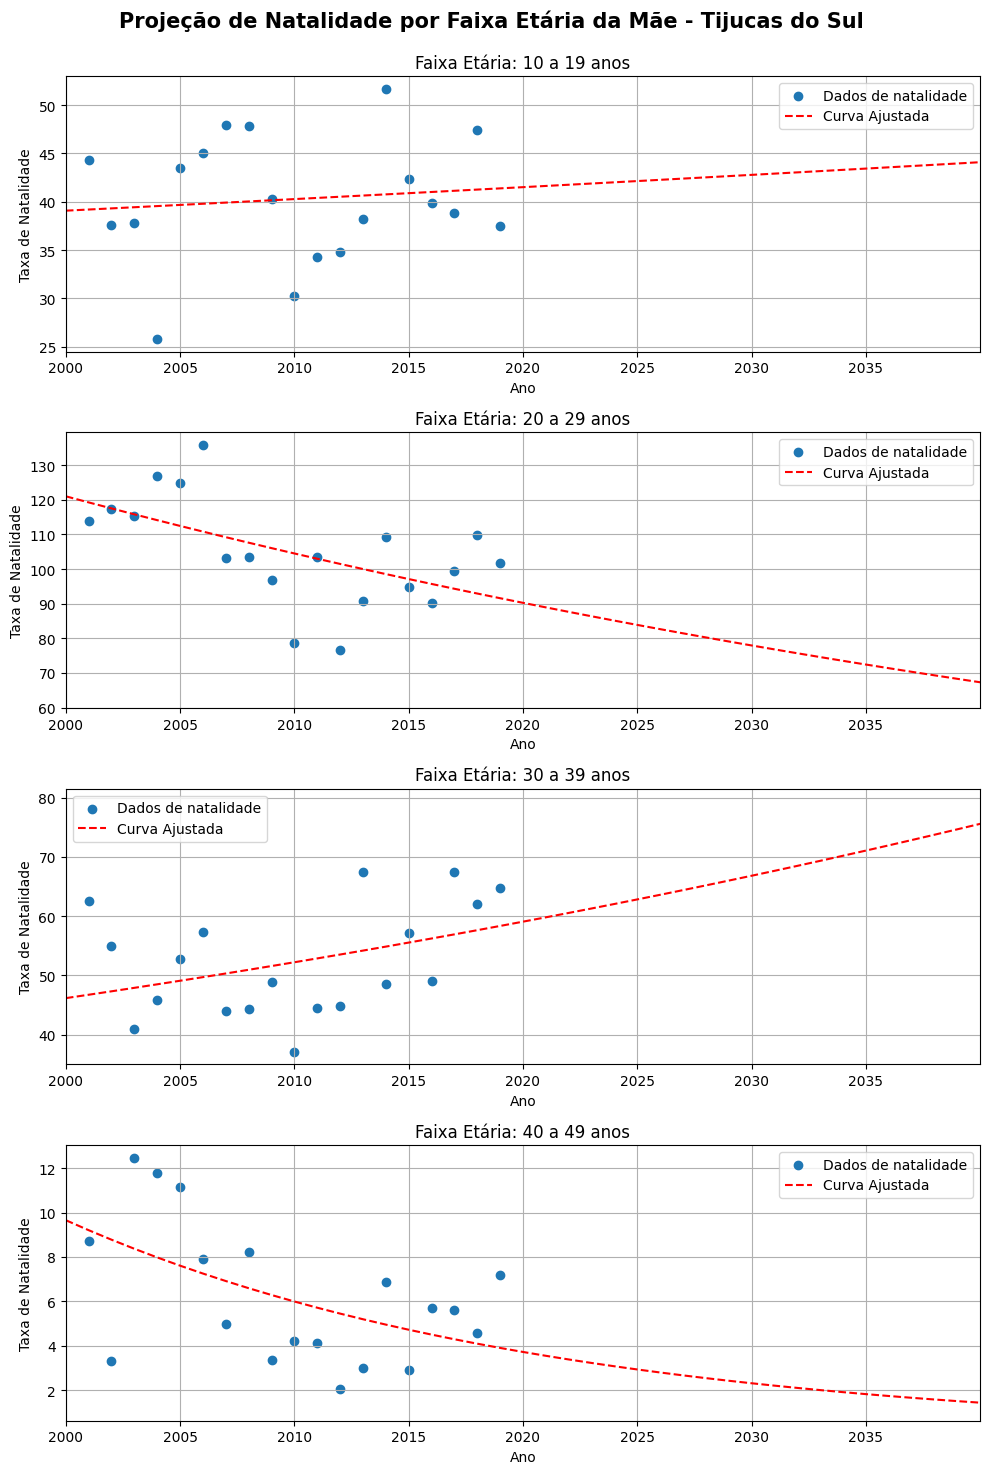

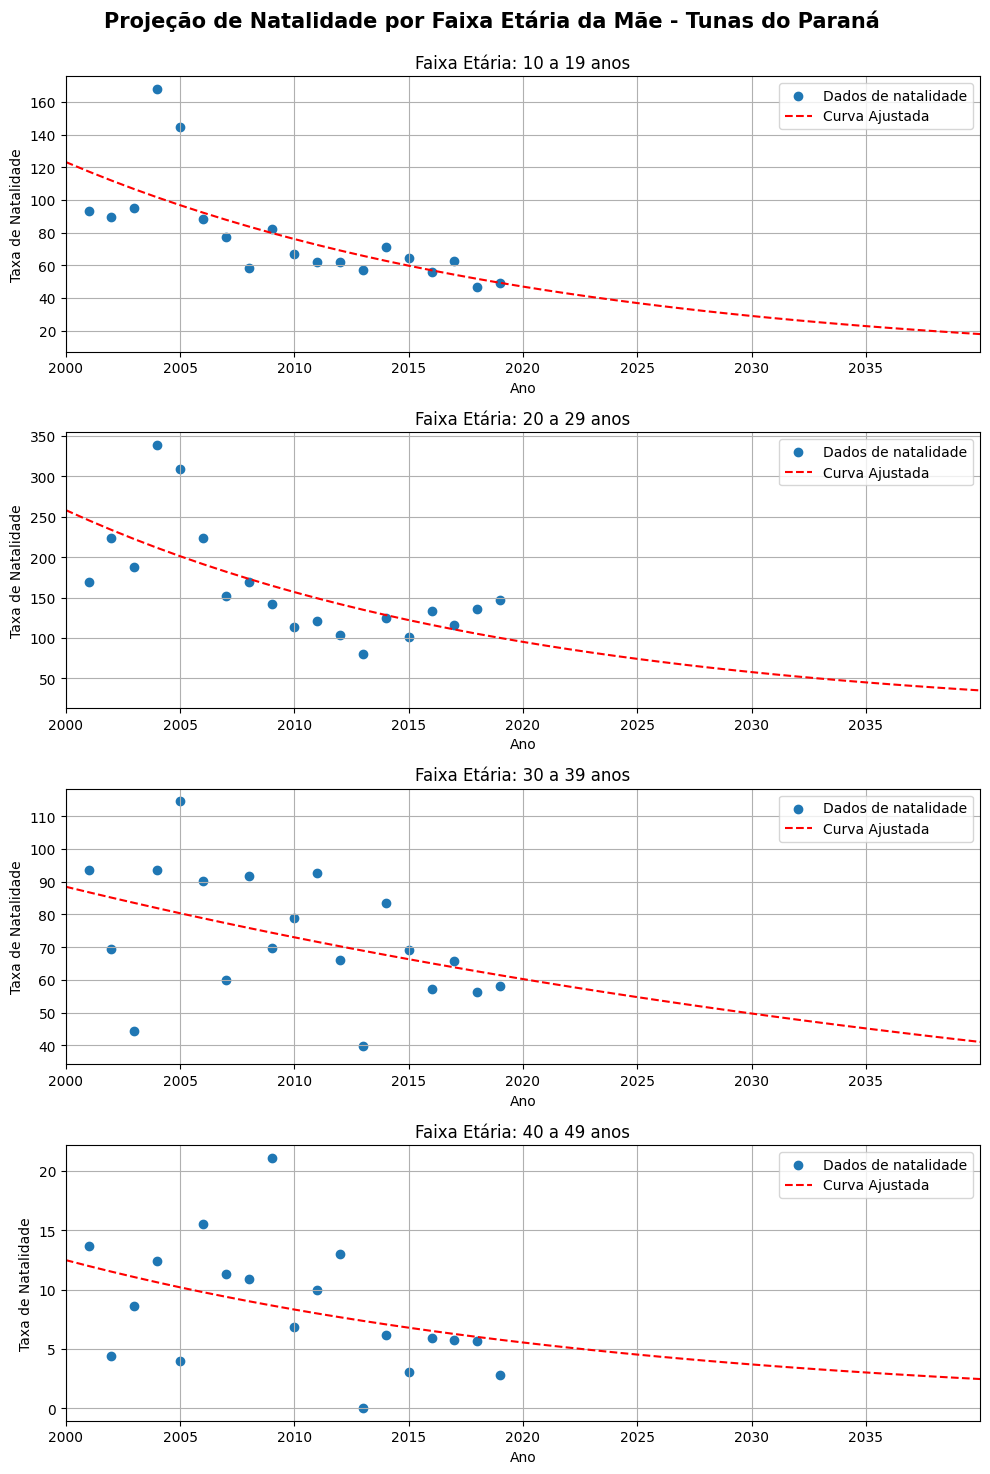

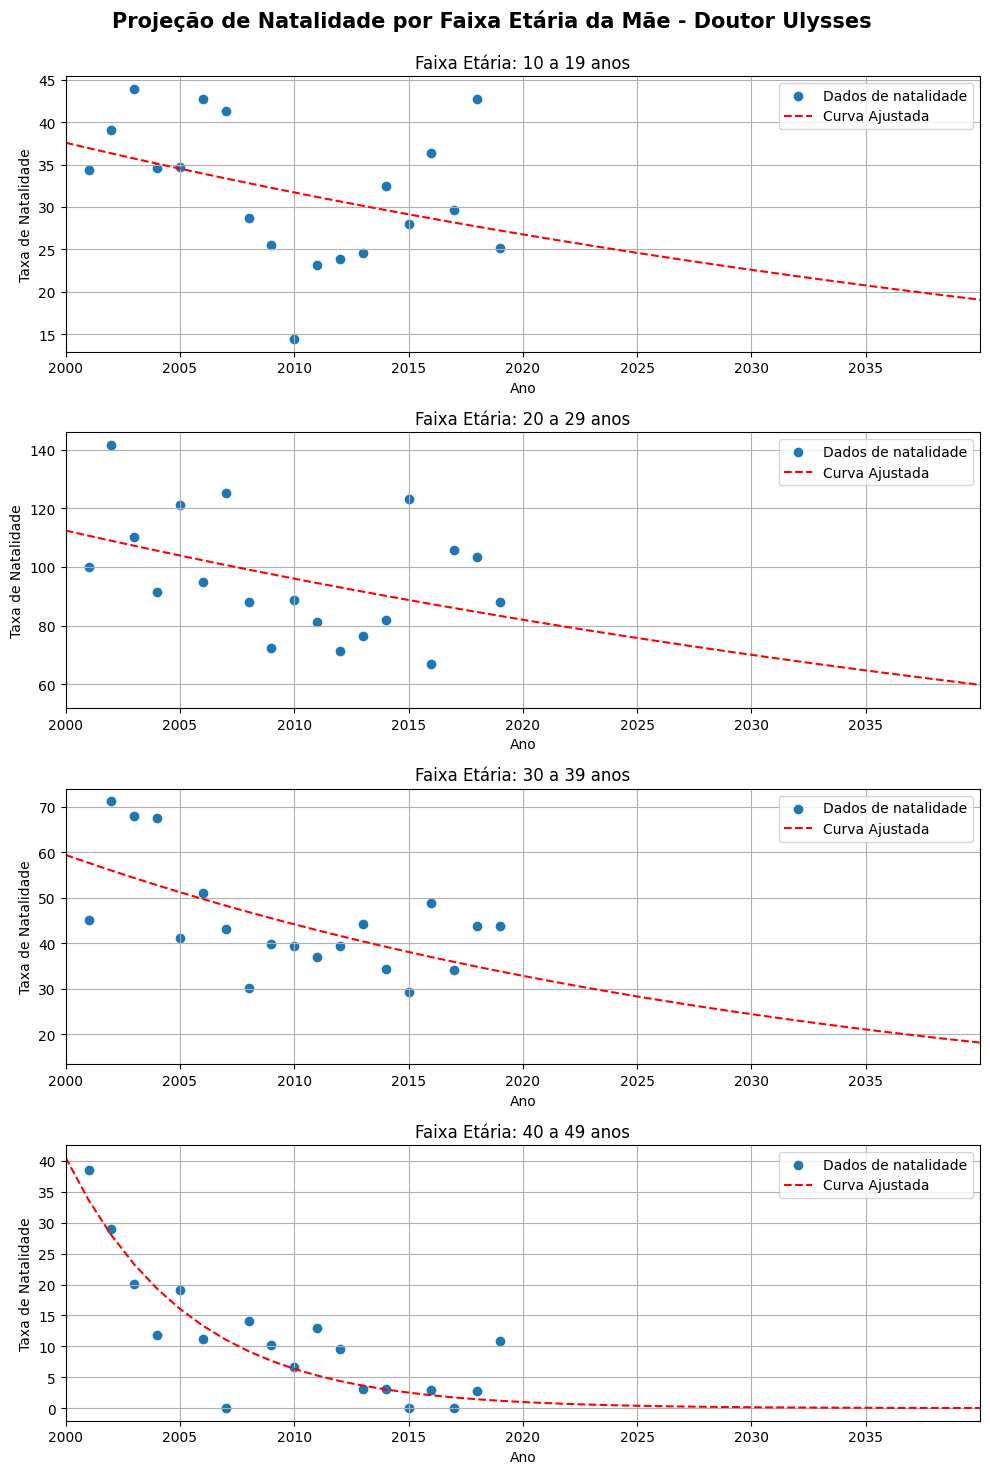

In [ ]:
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# supressão de mensagens de alerta
np.seterr(over='ignore', invalid='ignore')
import warnings
warnings.filterwarnings('ignore')

# Função para o modelo exponencial decrescente
def modelo_exponencial(x, constante, coeficiente):
    return constante * np.exp(coeficiente * (-x - 1))

### Função para o modelo logístico
### def modelo_linear(x, constante, coeficiente, limite):
###    return 

# DataFrame de resultados
resultados = pd.DataFrame(columns=['Município', 'Faixa Etária', 'Constante', 'Coeficiente'])

dict_dfs = dict()

# Preparação de dados necessários ao laço de iteração
df_birth_rate_by_mothers_age_group.reset_index(inplace=True)

plt.ioff()

for mun_id, mun in df_mun.itertuples():
    print(mun)


    faixas_etarias = df_birth_rate_by_mothers_age_group['Faixa Etária'].unique()
    num_plots = len(faixas_etarias)
    num_colunas = 1
    num_linhas = 4

    # Criação de subplots para cada faixa etária
    fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(10, 15))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    # laço de iteração
    for i, faixa_etaria in enumerate(faixas_etarias):
        if i >= num_plots:
            break  # Sair se todos os subplots já estiverem preenchidos
        
        # Filtragem do DataFrame para a faixa etária atual
        df_filtro = df_birth_rate_by_mothers_age_group[(df_birth_rate_by_mothers_age_group['Faixa Etária'] == faixa_etaria) & (df_birth_rate_by_mothers_age_group['Município'] == mun)]

        # Atribuição de dados de anos e natalidade a suas variáveis para o modelo
        anos = np.array(df_filtro.columns[3:], dtype=int) - 2000
        dados_natalidade = df_filtro.iloc[0, 3:].values.astype(float)

        # Ajuste do modelo exponencial aos dados
        try:
            params, _ = curve_fit(modelo_exponencial, anos, dados_natalidade, maxfev=10000)
            constante, coeficiente = params
            # Se o coeficiente for negativo, ajustar o modelo logístico
###           if coeficiente < 0:
###                params, _ = curve_fit(modelo_logistico, anos, dados_natalidade, maxfev=10000)
###                constante, coeficiente, limite = params
###                previsao = modelo_logistico(anos, constante, coeficiente, limite)
###            else:
            previsao = modelo_exponencial(anos, constante, coeficiente)
        except RuntimeError:
            constante, coeficiente = np.nan, np.nan
            previsao = np.nan * anos
        
        # Criação de um DataFrame temporário com os resultados atuais
        df_temp = pd.DataFrame({'Município':mun, 'Faixa Etária': [faixa_etaria],
                                'Constante': [constante], 'Coeficiente': [coeficiente]})
        
            # Calcular as previsões do modelo para os anos futuros
        anos_futuros = np.arange(0, 45)
        previsao = modelo_exponencial(anos_futuros, constante, coeficiente)
        
        # Concatenação do DataFrame temporário ao DataFrame de resultados
        resultados = pd.concat([resultados, df_temp], ignore_index=True)

        # Plotagem dos dados originais e a curva ajustada
        axs[i].scatter(anos + 2000, dados_natalidade, label='Dados de natalidade', marker='o')
        axs[i].plot(anos_futuros + 2000, previsao, label='Curva Ajustada', linestyle='--', color='red')
        axs[i].set_xlabel('Ano')
        axs[i].set_ylabel('Taxa de Natalidade')
        axs[i].set_title(f'Faixa Etária: {faixa_etaria}')
        axs[i].legend()
        axs[i].grid(True)
        axs[i].set_xlim(2000, 2040)  # Definir limite do eixo x de 2000 a 2040
        axs[i].set_xticks(np.arange(2000, 2040, 5))  # Definir marcações no eixo x a cada 5 anos

    # Exibir os subplots
    fig.suptitle(f'Projeção de Natalidade por Faixa Etária da Mãe - {mun} \n', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'../../br_demography/results/fig/{mun}.svg', format="svg")
    plt.savefig(f'../../br_demography/results/fig/{mun}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)
"""